In [6]:
import cv2
import numpy as np
import os
import glob

def select_circular_roi(image):
    # Create a window and set the mouse callback function
    roi_params = {'center': (0, 0), 'radius': 0, 'drawing': False, 'complete': False}
    
    def draw_circle(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            roi_params['center'] = (x, y)
            roi_params['drawing'] = True
        elif event == cv2.EVENT_MOUSEMOVE and roi_params['drawing']:
            roi_params['radius'] = int(np.sqrt((x - roi_params['center'][0])**2 + (y - roi_params['center'][1])**2))
        elif event == cv2.EVENT_LBUTTONUP:
            roi_params['drawing'] = False
            roi_params['complete'] = True

    cv2.namedWindow('Select ROI')
    cv2.setMouseCallback('Select ROI', draw_circle)

    while True:
        img_copy = image.copy()
        if roi_params['drawing'] or roi_params['complete']:
            cv2.circle(img_copy, roi_params['center'], roi_params['radius'], (0, 255, 0), 2)
        cv2.imshow('Select ROI', img_copy)
        key = cv2.waitKey(1) & 0xFF
        if key == 27 or roi_params['complete']:  # Exit on ESC
            break

    cv2.destroyWindow('Select ROI')
    return roi_params['center'], roi_params['radius']

def overlay_circular_roi(source_image, center, radius):
    mask = np.zeros(source_image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    masked_roi = cv2.bitwise_and(source_image, source_image, mask=mask)
    result_image = source_image.copy()

    x, y = center
    for c in range(3):  # Assuming a 3-channel image
        result_image[y-radius:y+radius, x-radius:x+radius, c] = np.where(mask[y-radius:y+radius, x-radius:x+radius] == 255,
                                                                         masked_roi[y-radius:y+radius, x-radius:x+radius, c],
                                                                         source_image[y-radius:y+radius, x-radius:x+radius, c])
    return result_image

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the overlay
    for image_path in image_paths:
        # Load the target image
        image = cv2.imread(image_path)

        # Select circular ROI
        center, radius = select_circular_roi(image)

        # Overlay the circular ROI on the same image
        result_image = overlay_circular_roi(image, center, radius)

        # Save the result
        result_image_path = os.path.join(directory_path, 'result_' + os.path.basename(image_path))
        cv2.imwrite(result_image_path, result_image)

    print("Processing complete. Results saved in the directory.")


Processing complete. Results saved in the directory.


In [11]:
import cv2
import numpy as np
import os
import glob

# Global variables for drawing
drawing_params = {'drawing': False, 'points': []}

def select_freehand_roi(image):
    # Function to handle mouse events
    def draw_roi(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing_params['drawing'] = True
            drawing_params['points'] = [(x, y)]
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing_params['drawing']:
                drawing_params['points'].append((x, y))
        elif event == cv2.EVENT_LBUTTONUP:
            drawing_params['drawing'] = False

    cv2.namedWindow('Select ROI')
    cv2.setMouseCallback('Select ROI', draw_roi)

    while True:
        img_copy = image.copy()

        if len(drawing_params['points']) > 0:
            # Draw all the points except the last one
            cv2.polylines(img_copy, [np.array(drawing_params['points'], np.int32)], False, (0, 255, 0), 2)

        cv2.imshow('Select ROI', img_copy)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # Exit on ESC
            break
        elif key == ord('c'):  # Clear the points if 'c' is pressed
            drawing_params['points'] = []

    cv2.destroyWindow('Select ROI')
    return drawing_params['points']

def overlay_freehand_roi(source_image, points):
    mask = np.zeros(source_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(points, np.int32)], 255)

    masked_roi = cv2.bitwise_and(source_image, source_image, mask=mask)
    result_image = source_image.copy()

    result_image[np.where(mask == 255)] = masked_roi[np.where(mask == 255)]
    return result_image, mask

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the overlay
    for image_path in image_paths:
        # Load the target image
        image = cv2.imread(image_path)

        # Select freehand ROI
        points = select_freehand_roi(image)

        # Overlay the freehand ROI on the same image
        result_image, mask = overlay_freehand_roi(image, points)

        # Save the result
        result_image_path = os.path.join(directory_path, 'result_' + os.path.basename(image_path))
        cv2.imwrite(result_image_path, result_image)

        # Optionally save the mask for debugging or analysis
        mask_path = os.path.join(directory_path, 'mask_' + os.path.basename(image_path))
        cv2.imwrite(mask_path, mask)

    print("Processing complete. Results saved in the directory.")


Processing complete. Results saved in the directory.


In [15]:
import cv2
import numpy as np
import os
import glob

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store ROIs
    rois = []

    # Process each contour
    for contour in contours:
        # Find the bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate center and radius for circular ROI
        center = (x + w // 2, y + h // 2)
        radius = max(w // 2, h // 2)

        # Adjust radius for the circular ROI
        radius = int(radius * 1.2)  # Increase by 20%

        # Store the ROI (center, radius)
        rois.append((center, radius))

    return rois

def overlay_circular_roi(image, center, radius, color=(0, 255, 0), thickness=2):
    overlay = image.copy()

    # Draw the circular ROI on the overlay
    cv2.circle(overlay, center, radius, color, thickness)

    # Combine the overlay with the original image
    result = cv2.addWeighted(overlay, 0.5, image, 0.5, 0)

    return result

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the overlay
    for image_path in image_paths:
        # Load the target image
        image = cv2.imread(image_path)

        # Find ROIs based on intensity
        rois = find_max_intensity_roi(image)

        # Overlay circular ROIs on the image
        for center, radius in rois:
            image = overlay_circular_roi(image, center, radius)

        # Save the result
        result_image_path = os.path.join(directory_path, 'result_' + os.path.basename(image_path))
        cv2.imwrite(result_image_path, image)

    print("Processing complete. Results saved in the directory.")


Processing complete. Results saved in the directory.


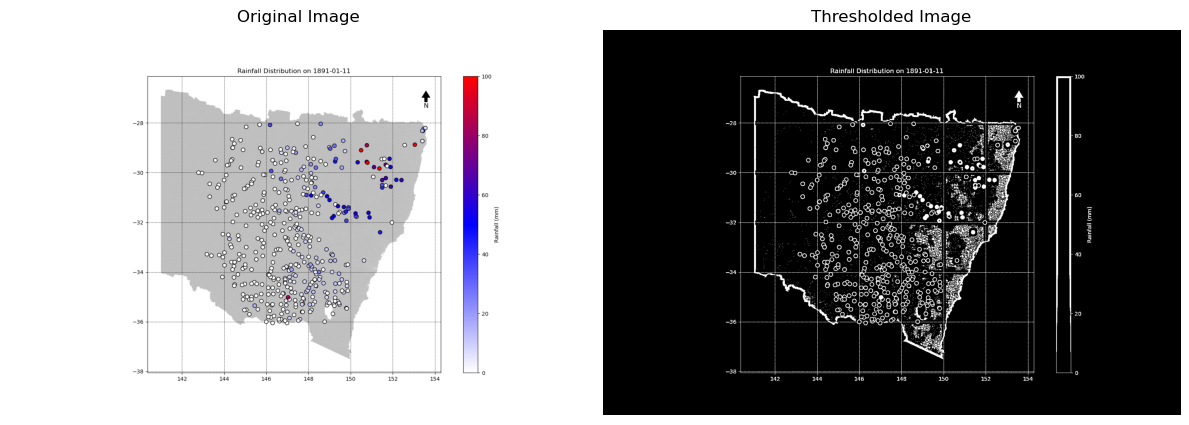

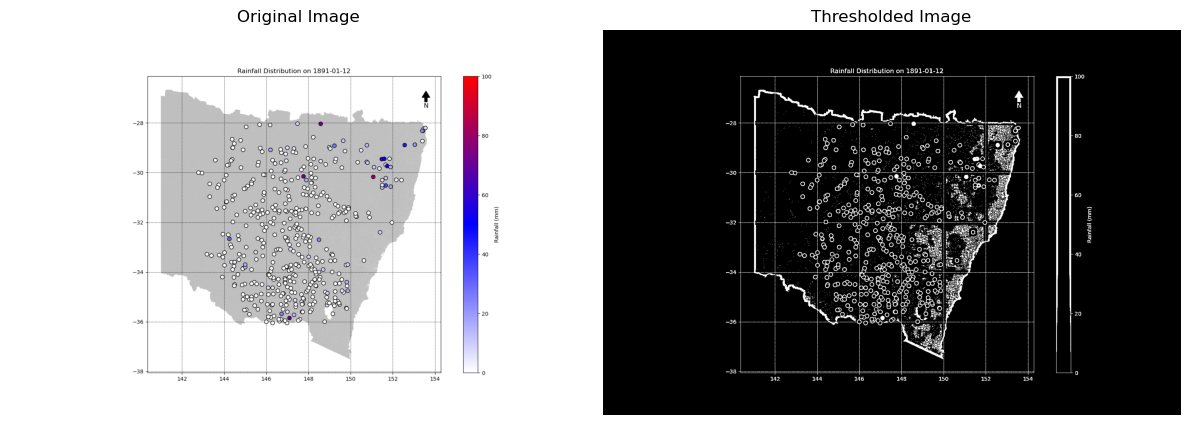

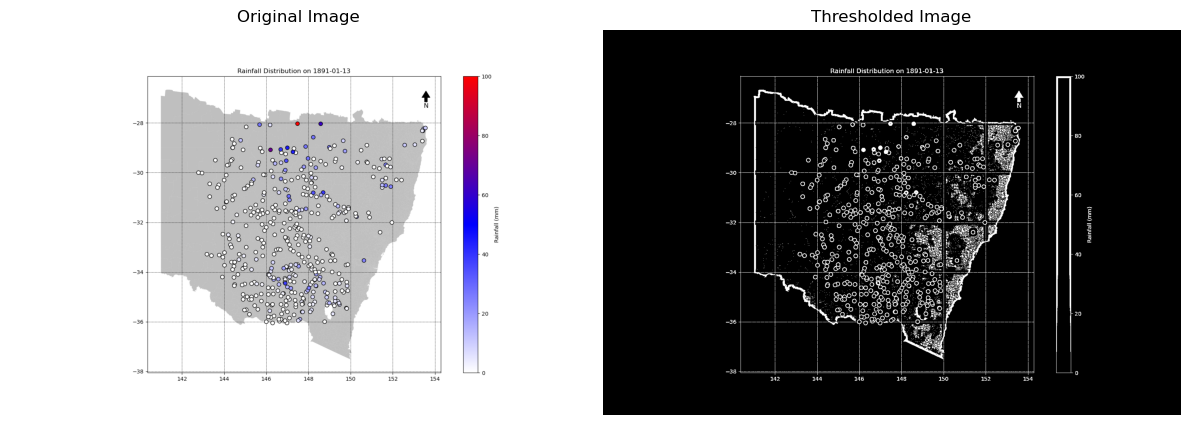

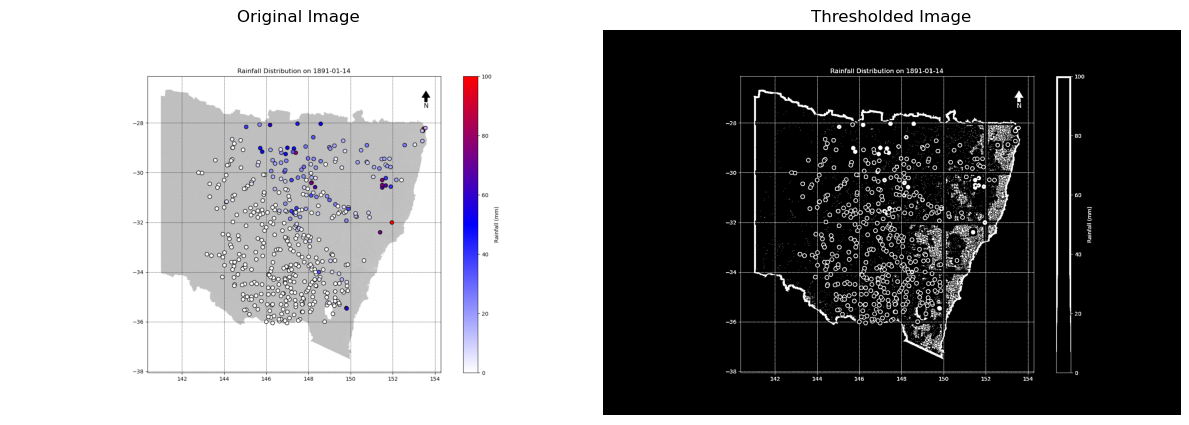

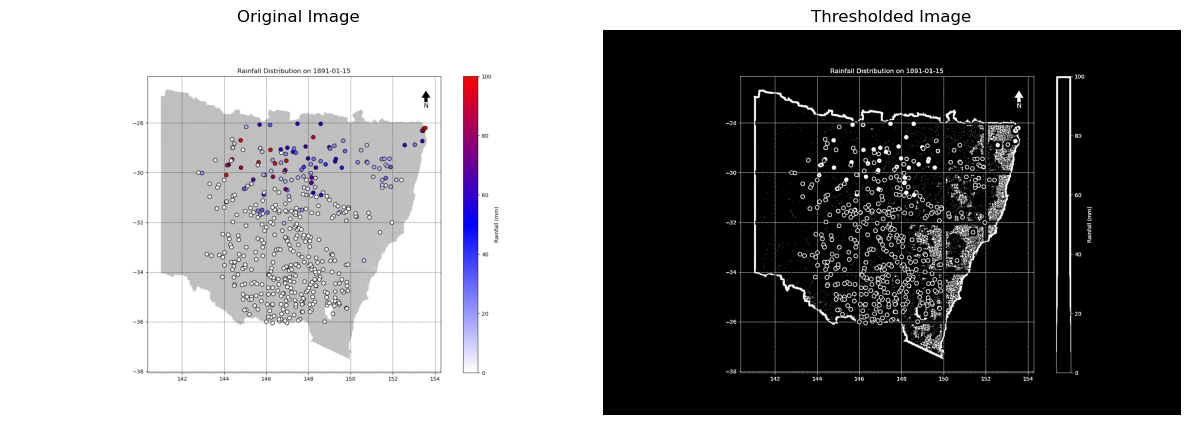

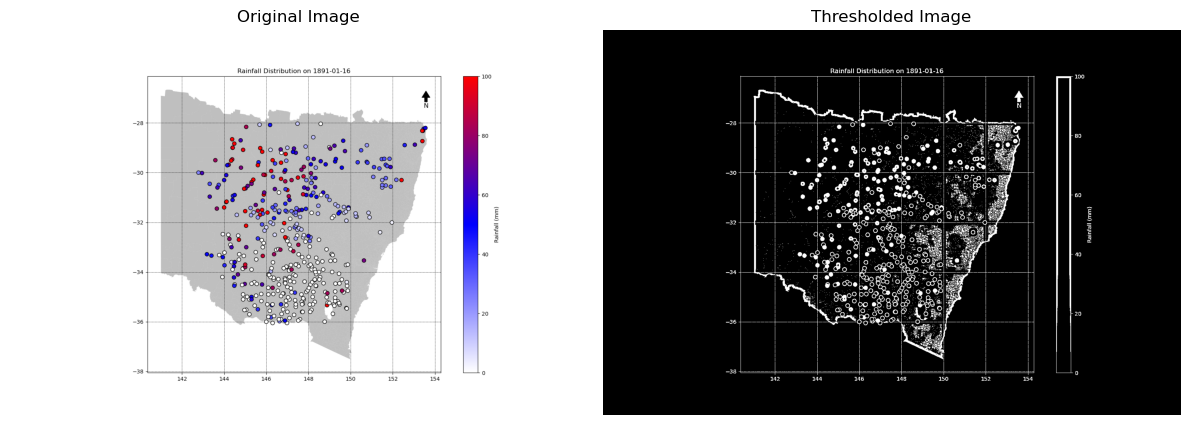

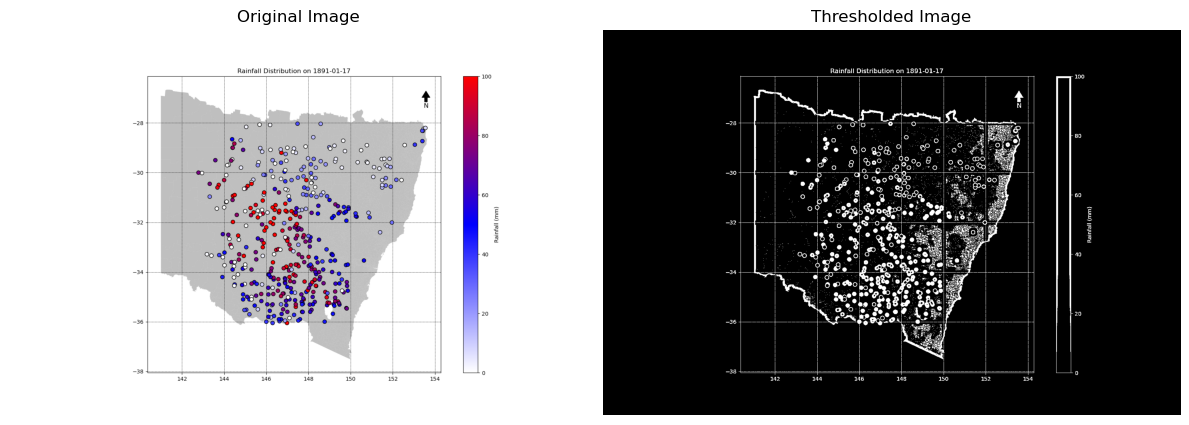

In [26]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

# Function to find max intensity ROI
def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to isolate areas of high intensity (red dots)
    thresholded = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    return thresholded

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the thresholding
    for image_path in image_paths:
        # Load the image
        image = cv2.imread(image_path)

        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)

        # Display original and thresholded images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(thresholded_image, cmap='gray')
        plt.title('Thresholded Image')
        plt.axis('off')

        plt.tight_layout()
        plt.show()



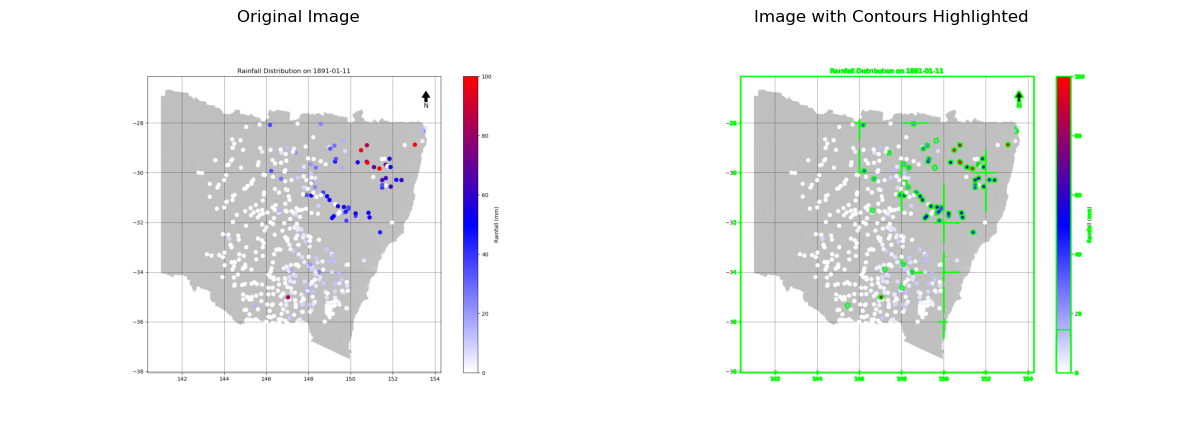

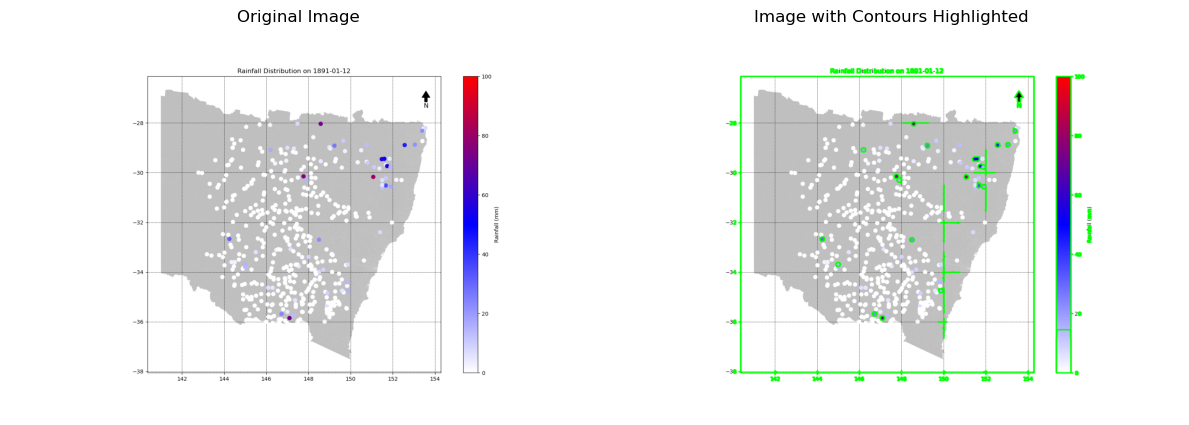

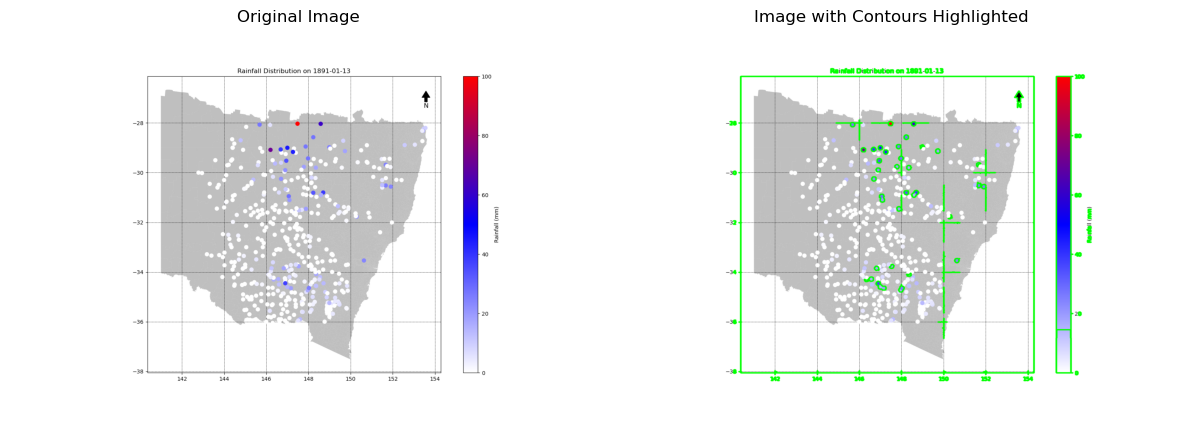

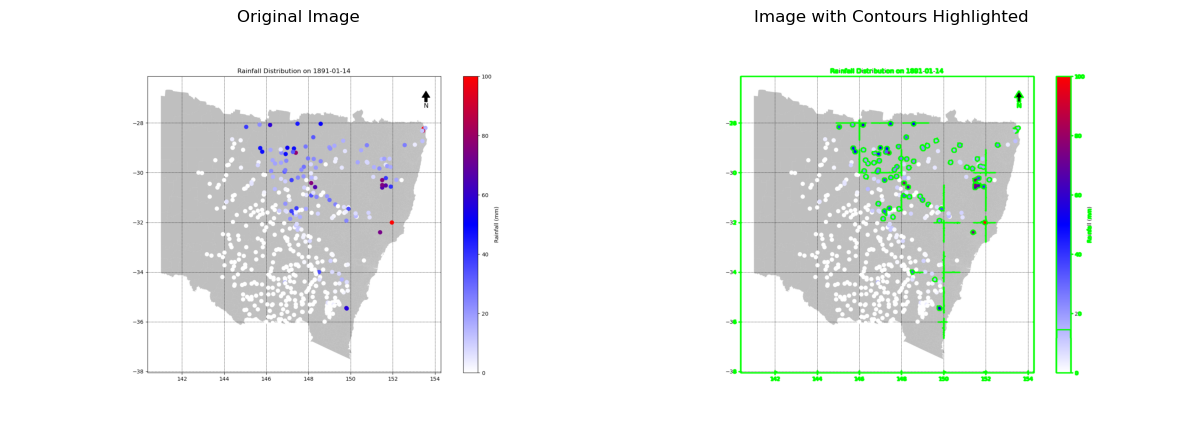

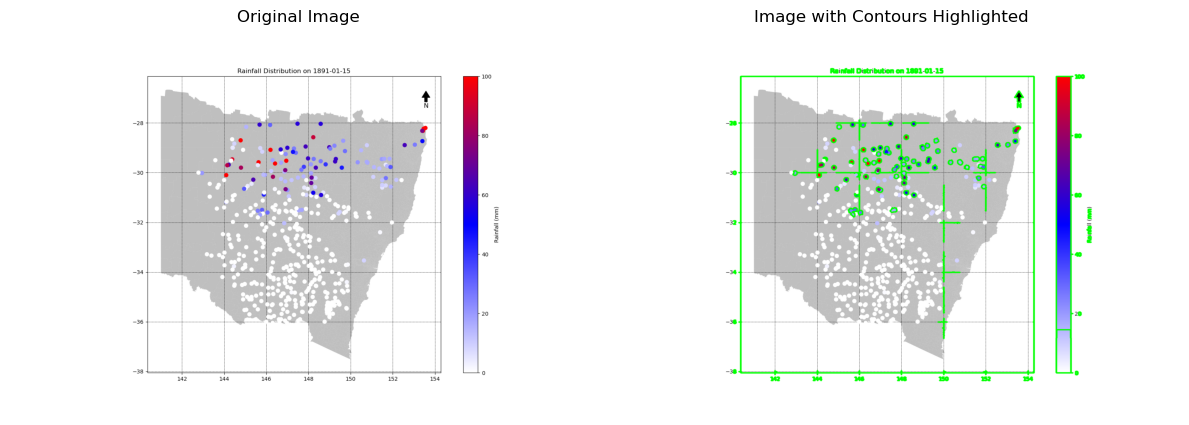

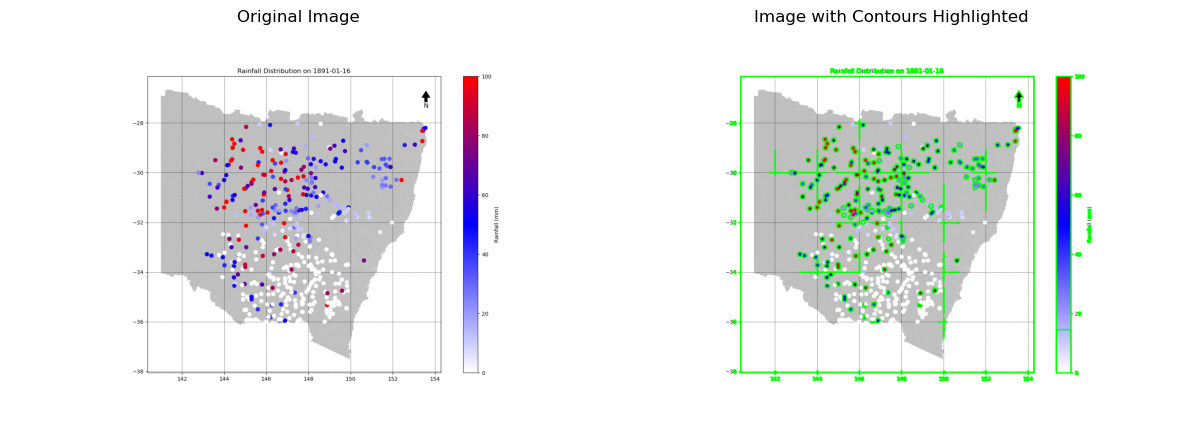

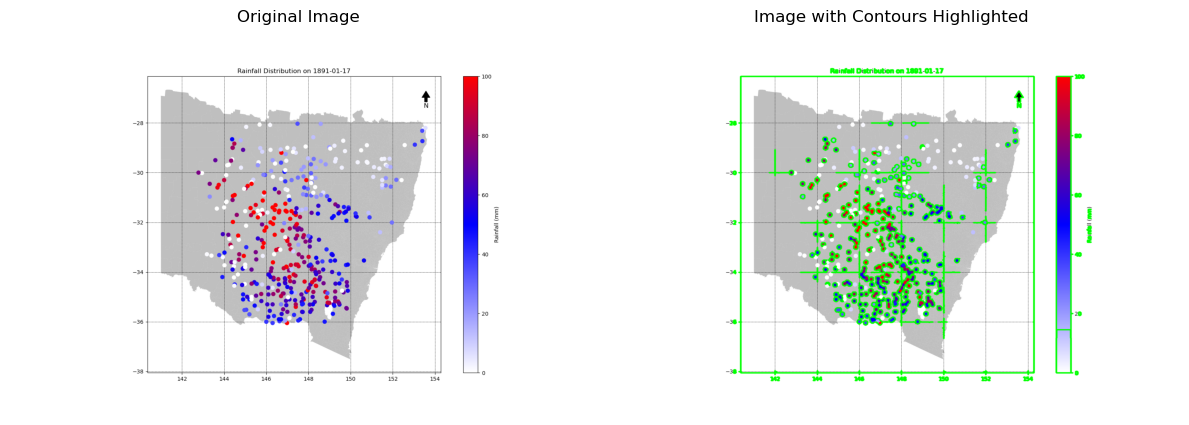

In [96]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)

    return thresholded


# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station_noborder\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the thresholding
    for image_path in image_paths:
        # Load the image
        image = cv2.imread(image_path)

        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)

        # Find contours
        contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Filter contours based on area threshold (adjust as needed)
        min_contour_area = 10  # Example threshold for minimum contour area
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]


        # Draw contours on the original image
        image_with_contours = image.copy()
        cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2,cv2.LINE_AA)  # Draw all contours in green

        # Collect detection information
        detections = []
        thresh = 100  # Example threshold for area filtering
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area > thresh:
                detections.append([x, y, x + w, y + h, area])
        
        detections = np.array(detections)

        # Display original and thresholded images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
        plt.title('Image with Contours Highlighted')
        plt.axis('off')
       
       
        plt.tight_layout()
        plt.show()



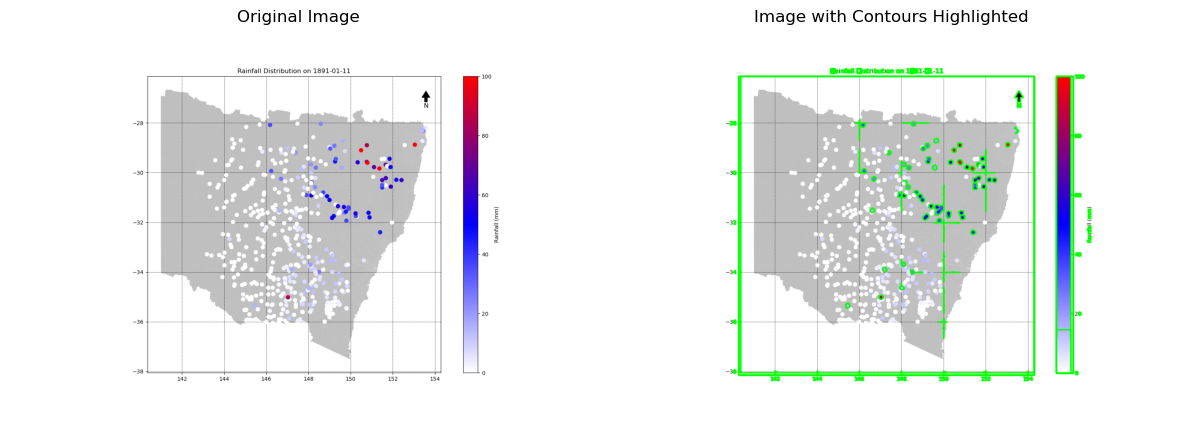

Detections for Rainfall_Map_1891-01-11.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


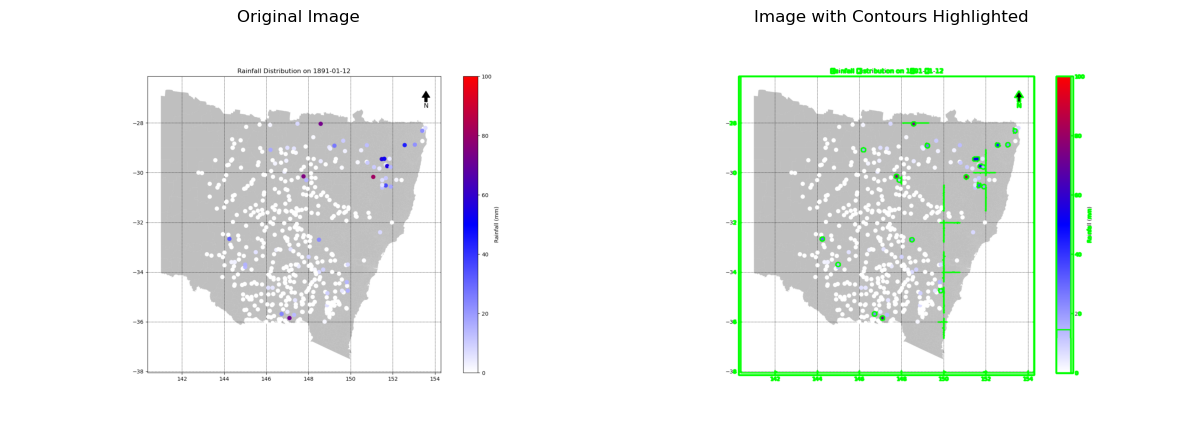

Detections for Rainfall_Map_1891-01-12.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


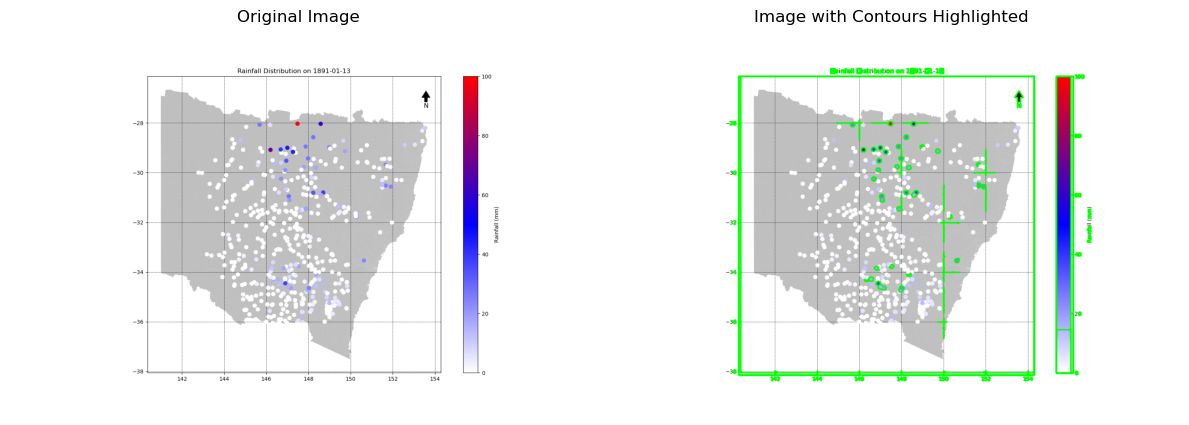

Detections for Rainfall_Map_1891-01-13.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 874  100  883  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


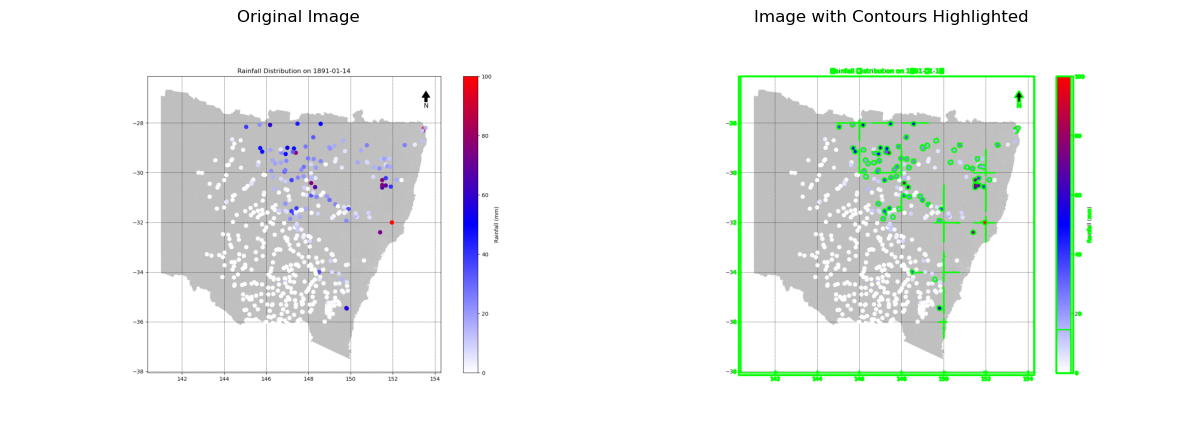

Detections for Rainfall_Map_1891-01-14.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 874  100  883  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


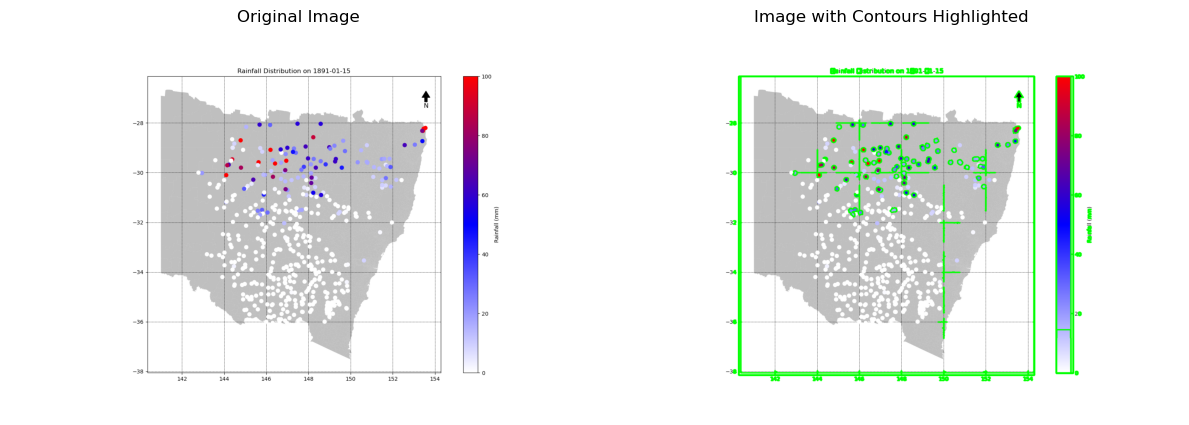

Detections for Rainfall_Map_1891-01-15.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


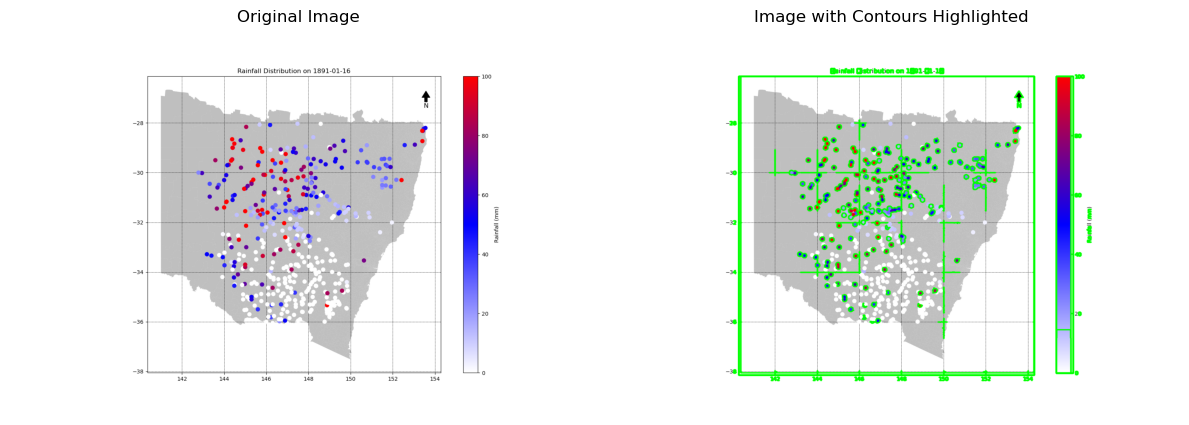

Detections for Rainfall_Map_1891-01-16.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 874  100  883  112]
 [ 836  100  845  112]
 [ 798  100  807  112]]


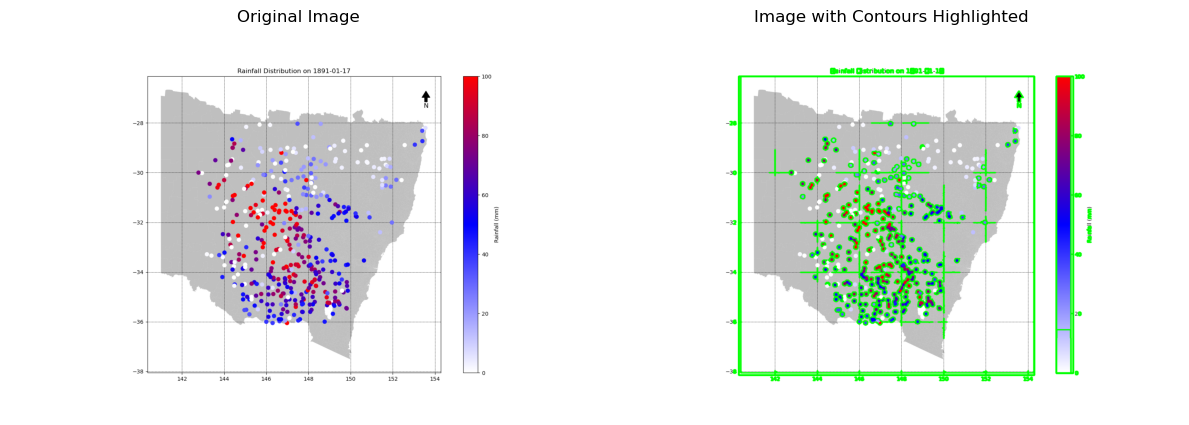

Detections for Rainfall_Map_1891-01-17.png:
[[ 352  120 1119  896]
 [1176  120 1220  891]
 [ 659  100  670  112]
 [ 591  100  601  112]
 [ 836  100  845  112]
 [ 798  100  807  112]
 [ 874  100  883  112]]


In [93]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
    return thresholded

def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be sorted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area 
                    [[x1, y1, x2, y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained 
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(boxes)):
            # Check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # Remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order[:]:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

def draw_bboxes(frame, detections):
    for det in detections:
        x1, y1, x2, y2 = det
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

def create_gif_from_images(save_path: str, image_path: str, ext: str,duration: int = 1500) -> None:
    """ Creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    """
    ext = ext.replace('.', '')
    image_paths = sorted(glob.glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=duration, loop=0)

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station_noborder\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Path to save the output GIF
output_gif_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station_noborder\output.gif'


# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the thresholding
    for image_path in image_paths:
        # Load the image
        image = cv2.imread(image_path)

        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)

        # Find contours
        contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Filter contours based on area threshold (adjust as needed)
        min_contour_area = 10  # Example threshold for minimum contour area
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        # Draw contours on the original image
        image_with_contours = image.copy()
        cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)  # Draw all contours in green

        # Collect detection information
        detections = []
        thresh = 100  # Example threshold for area filtering
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area > thresh:
                detections.append([x, y, x + w, y + h, area])
        
        detections = np.array(detections)
        if len(detections) == 0:
            continue

        # Separate bboxes and scores
        bboxes = detections[:, :4]
        scores = detections[:, -1]

        # Perform Non-Maximal Suppression on initial detections
        nms_detections = non_max_suppression(bboxes, scores, threshold=1e-3)

        # Draw bounding boxes on the original image
        draw_bboxes(image_with_contours, nms_detections)

        # Display original and thresholded images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
        plt.title('Image with Contours Highlighted')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print detections for verification
        print(f"Detections for {os.path.basename(image_path)}:")
        print(nms_detections)

    # Create GIF from processed images
    create_gif_from_images(output_gif_path, directory_path, '.png')



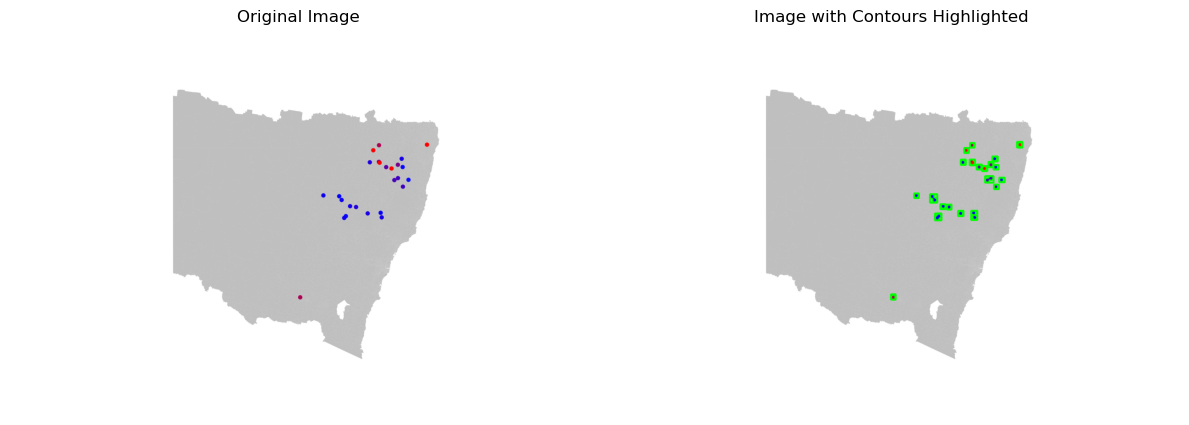

Detections for Rainfall_Map_1891-01-11.png:
[[ 848  426  867  448]
 [ 955  469  971  493]
 [ 991  379 1013  396]
 [ 861  476  878  494]
 [ 951  336  965  351]
 [1074  290 1088  305]
 [ 921  469  935  483]
 [1000  342 1013  356]
 [ 969  349  983  362]
 [ 983  353  997  366]
 [ 928  336  941  350]
 [ 875  452  889  465]
 [1010  328 1024  341]
 [1028  383 1042  395]
 [ 747  686  759  700]
 [1013  350 1026  362]
 [1014  401 1027  413]
 [ 892  453  904  466]
 [ 937  306  949  319]
 [ 952  293  964  305]
 [ 807  424  819  436]]


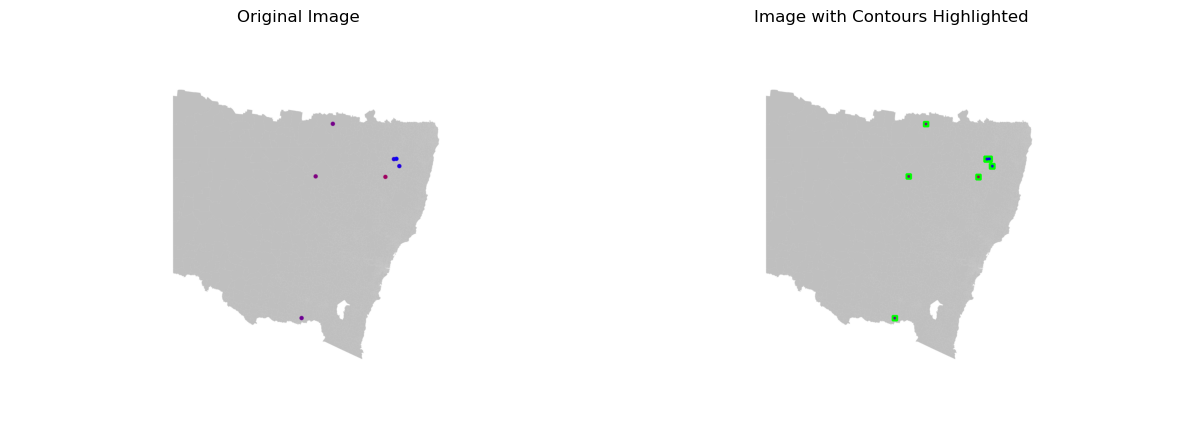

Detections for Rainfall_Map_1891-01-12.png:
[[ 989  328 1009  342]
 [1003  347 1016  360]
 [ 968  375  980  388]
 [ 832  238  844  250]
 [ 787  374  799  386]
 [ 751  742  763  754]]


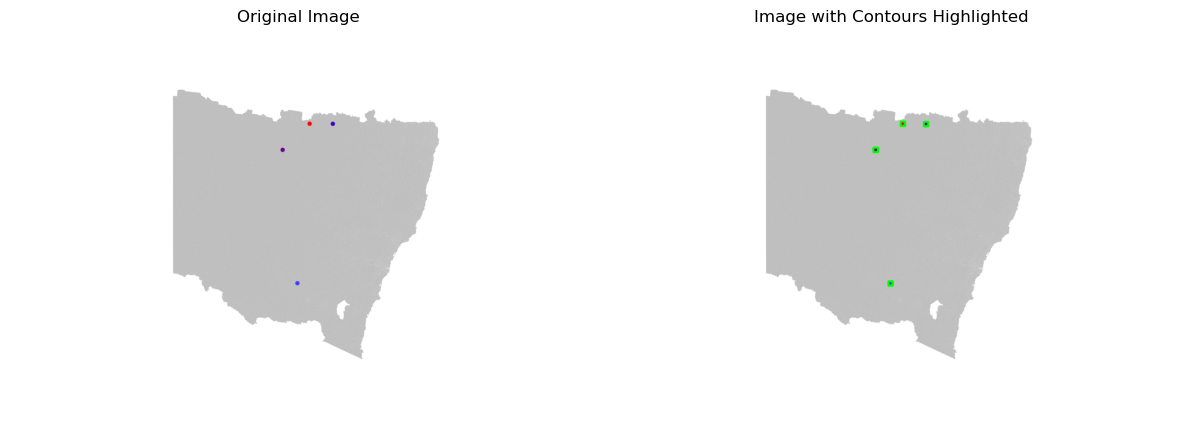

Detections for Rainfall_Map_1891-01-13.png:
[[701 305 714 317]
 [772 237 784 249]
 [832 238 844 250]
 [740 652 752 664]]


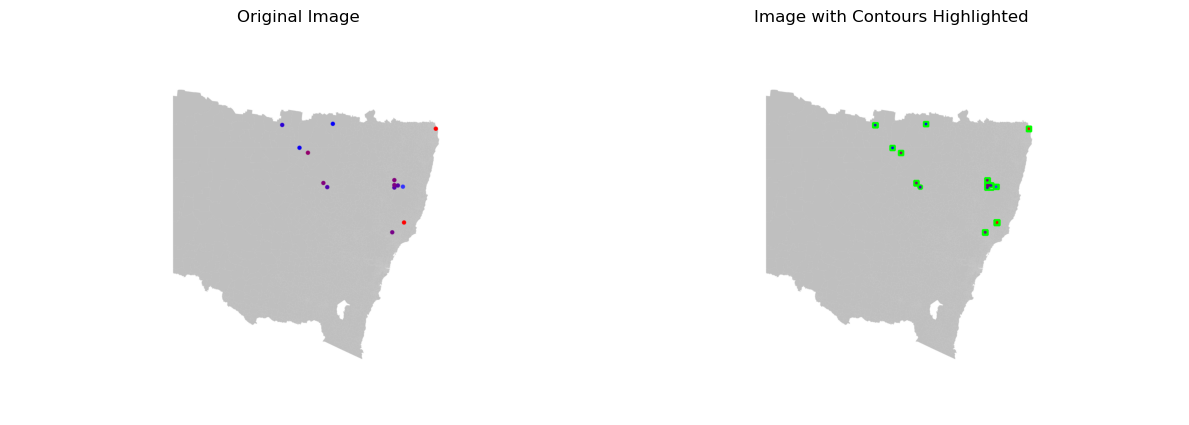

Detections for Rainfall_Map_1891-01-14.png:
[[ 991  397 1013  415]
 [1015  493 1029  507]
 [ 985  519  998  532]
 [ 700  241  713  253]
 [1099  250 1111  263]
 [ 991  384 1004  396]
 [ 807  391  819  404]
 [1014  401 1027  413]
 [ 832  238  844  250]
 [ 745  300  757  312]
 [ 767  313  779  325]]


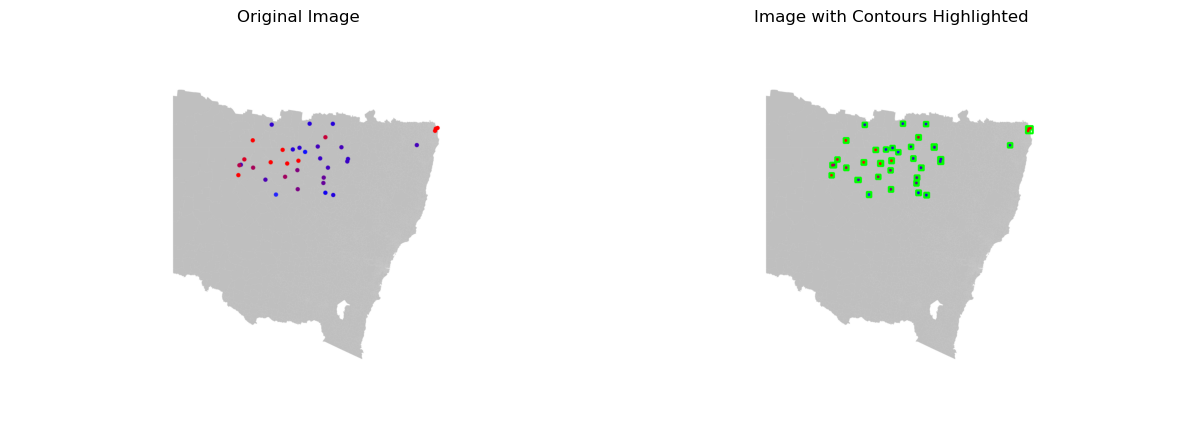

Detections for Rainfall_Map_1891-01-15.png:
[[1097  249 1115  268]
 [ 869  329  883  348]
 [ 852  296  866  311]
 [ 589  344  605  357]
 [ 713  339  727  353]
 [ 742  332  755  346]
 [ 654  383  669  395]
 [ 812  416  825  429]
 [ 819  351  832  364]
 [ 670  337  683  350]
 [ 833  422  846  435]
 [ 624  280  637  293]
 [ 812  272  825  285]
 [ 684  420  696  434]
 [ 625  351  637  364]
 [ 741  407  753  420]
 [ 807  391  819  404]
 [ 808  377  821  389]
 [ 701  305  714  317]
 [ 799  327  811  340]
 [1050  293 1062  305]
 [ 793  297  805  309]
 [ 760  311  772  323]
 [ 740  358  752  370]
 [ 587  371  599  383]
 [ 708  375  720  387]
 [ 745  300  757  312]
 [ 832  238  844  250]
 [ 602  330  614  342]
 [ 728  304  740  316]
 [ 673  240  685  252]
 [ 772  237  784  249]]


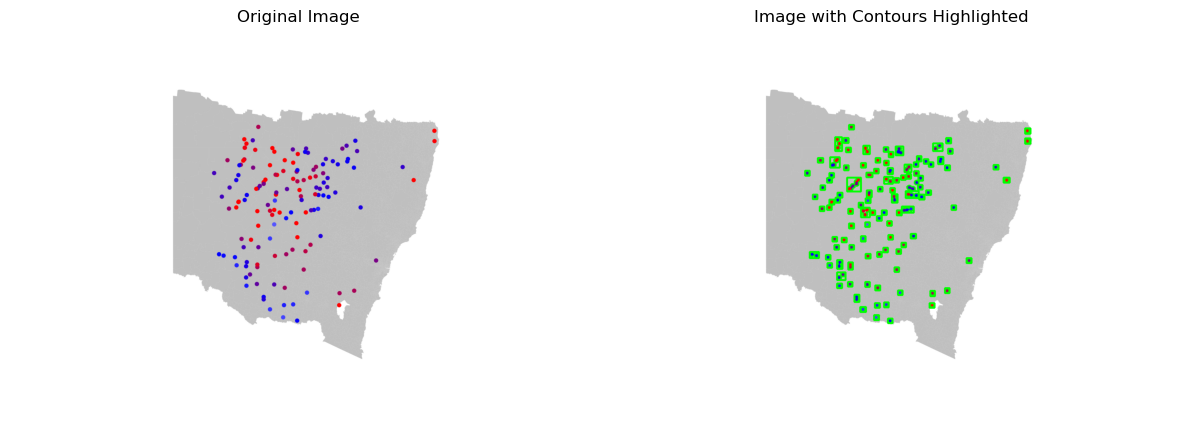

Detections for Rainfall_Map_1891-01-16.png:
[[ 633  383  669  419]
 [ 589  330  614  357]
 [ 602  278  620  314]
 [ 785  418  819  436]
 [ 669  461  692  486]
 [ 856  294  881  314]
 [ 775  458  806  474]
 [ 759  302  779  325]
 [ 607  629  629  649]
 [ 729  381  752  399]
 [ 536  576  560  592]
 [ 675  300  692  322]
 [ 782  349  800  369]
 [ 749  426  764  448]
 [ 607  597  621  620]
 [ 869  329  883  348]
 [ 652  687  665  706]
 [ 684  416  697  434]
 [ 636  603  648  622]
 [ 738  358  752  374]
 [1039  383 1055  396]
 [1095  255 1109  269]
 [1095  281 1109  295]
 [ 667  719  682  732]
 [ 683  370  699  382]
 [ 820  427  834  440]
 [ 890  280  903  294]
 [ 887  351  900  364]
 [ 943  592  956  605]
 [ 608  422  621  435]
 [ 762  468  775  481]
 [ 624  280  637  293]
 [ 703  740  716  753]
 [ 706  663  719  676]
 [ 587  440  600  453]
 [ 638  502  651  515]
 [ 669  535  681  549]
 [ 741  316  753  330]
 [ 814  327  826  341]
 [ 557  332  571  344]
 [ 849  677  861  691]
 [ 798  529  

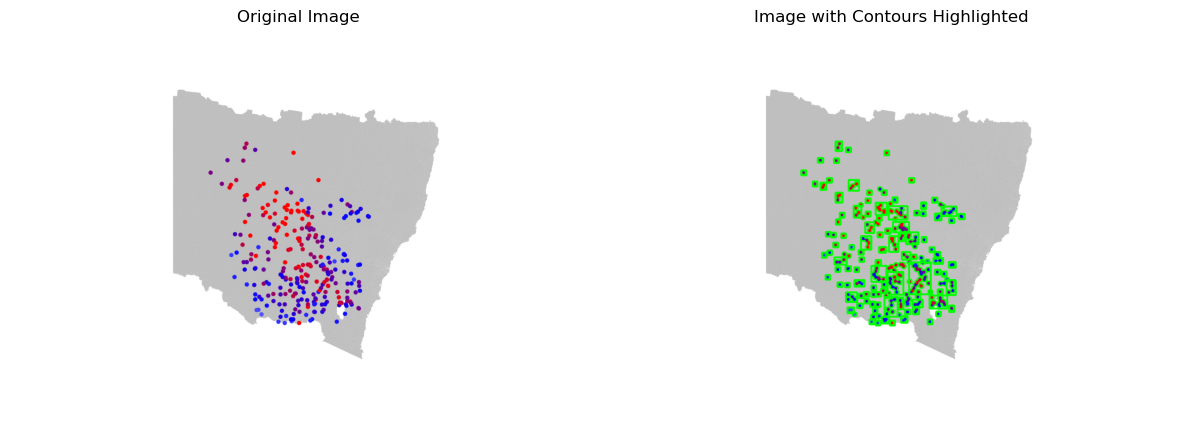

Detections for Rainfall_Map_1891-01-17.png:
[[794 603 850 686]
 [738 628 779 687]
 [730 693 764 744]
 [741 457 790 492]
 [696 612 735 654]
 [847 689 893 723]
 [752 498 794 525]
 [786 525 818 556]
 [742 535 766 576]
 [878 458 917 483]
 [669 535 696 570]
 [891 649 915 688]
 [707 448 736 480]
 [637 389 664 417]
 [630 681 659 706]
 [680 499 703 527]
 [650 456 670 487]
 [600 590 632 609]
 [803 700 829 720]
 [603 422 621 448]
 [652 649 678 666]
 [775 576 797 596]
 [765 694 779 725]
 [603 289 620 314]
 [857 592 882 607]
 [723 745 742 762]
 [767 528 783 548]
 [861 476 878 494]
 [773 743 790 760]
 [804 720 820 738]
 [564 396 579 415]
 [897 602 915 617]
 [716 563 734 578]
 [634 720 651 735]
 [825 447 838 465]
 [860 576 875 591]
 [898 715 911 732]
 [923 477 938 491]
 [732 515 746 529]
 [707 597 721 610]
 [751 434 764 448]
 [861 622 875 635]
 [629 613 643 626]
 [744 754 757 767]
 [514 364 527 377]
 [712 525 725 538]
 [847 564 860 577]
 [681 471 694 484]
 [854 435 867 448]
 [783 726 797 738]
 [659 

In [25]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
    return thresholded

def remove_contained_bboxes(boxes):
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(boxes)):
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

def non_max_suppression(boxes, scores, threshold=1e-1):
    boxes = boxes[np.argsort(scores)[::-1]]
    order = remove_contained_bboxes(boxes)
    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order[:]:
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

def draw_bboxes(frame, detections):
    for det in detections:
        x1, y1, x2, y2 = det
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

def create_gif_from_images(save_path: str, image_path: str, ext: str, duration: int = 1500) -> None:
    ext = ext.replace('.', '')
    image_paths = sorted(glob.glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]
    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=duration, loop=0)

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Path to save the output GIF
output_gif_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\output.gif'

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Iterate over all images and apply the thresholding
    for image_path in image_paths:
        # Load the image
        image = cv2.imread(image_path)

        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)

        # Create a mask to exclude borders
        mask = np.zeros_like(thresholded_image)
        h, w = thresholded_image.shape
        cv2.rectangle(mask, (10, 10), (w-10, h-10), 255, -1)
        masked_thresholded_image = cv2.bitwise_and(thresholded_image, thresholded_image, mask=mask)

        # Find contours
        contours, _ = cv2.findContours(masked_thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Filter contours based on area threshold (adjust as needed)
        min_contour_area = 50  # Example threshold for minimum contour area
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        # Draw contours on the original image
        image_with_contours = image.copy()
        cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)

        # Collect detection information
        detections = []
        thresh = 100  # Example threshold for area filtering
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area > thresh:
                detections.append([x, y, x + w, y + h, area])
        
        detections = np.array(detections)
        if len(detections) == 0:
            continue

        # Separate bboxes and scores
        bboxes = detections[:, :4]
        scores = detections[:, -1]

        # Perform Non-Maximal Suppression on initial detections
        nms_detections = non_max_suppression(bboxes, scores, threshold=1e-3)

        # Draw bounding boxes on the original image
        draw_bboxes(image_with_contours, nms_detections)

        # Display original and thresholded images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
        plt.title('Image with Contours Highlighted')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print detections for verification
        print(f"Detections for {os.path.basename(image_path)}:")
        print(nms_detections)

    # Create GIF from processed images
    create_gif_from_images(output_gif_path, directory_path, '.png')


Processing image 1/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-11.png


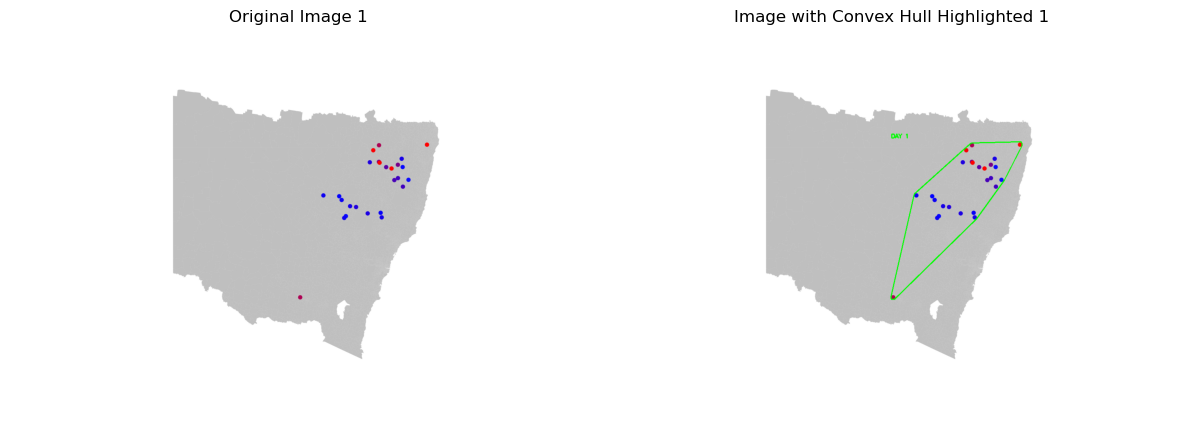

Processing image 2/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-12.png


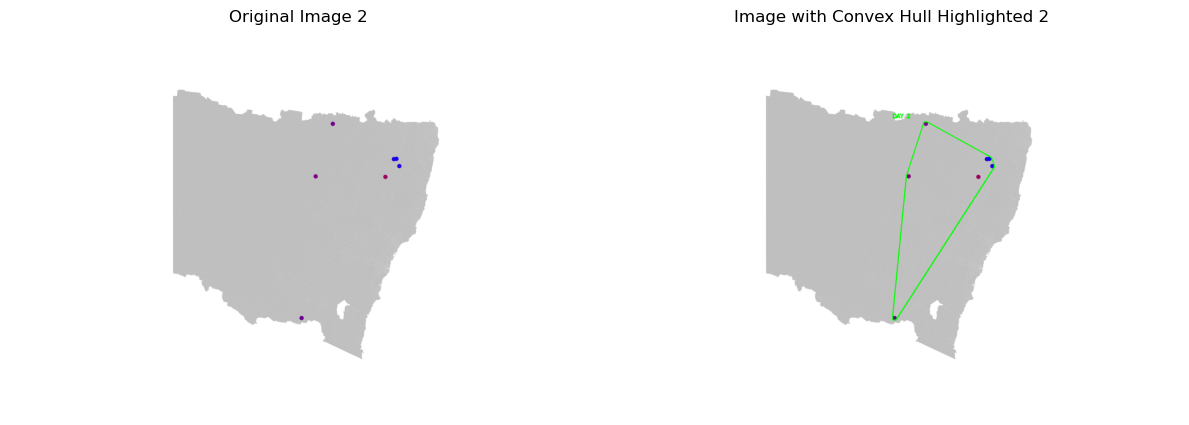

Processing image 3/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-13.png


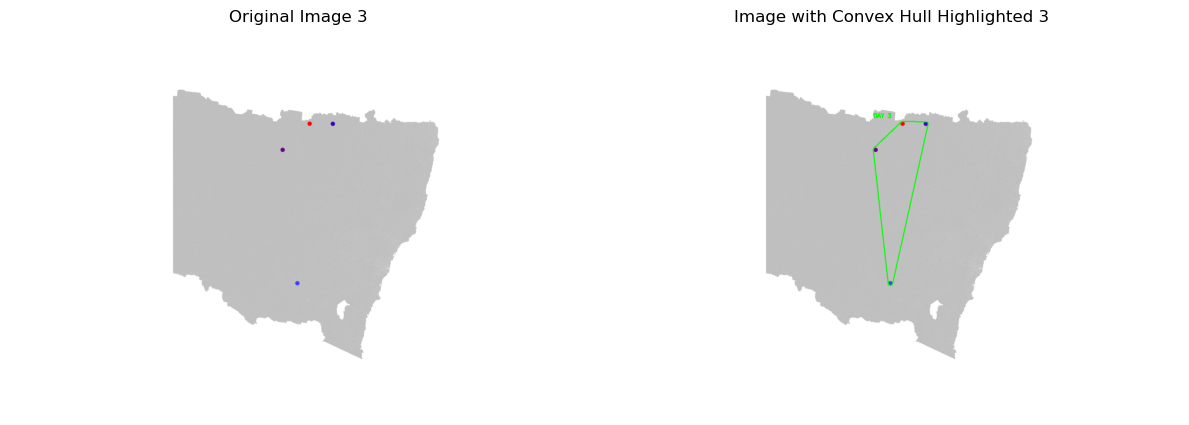

Processing image 4/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-14.png


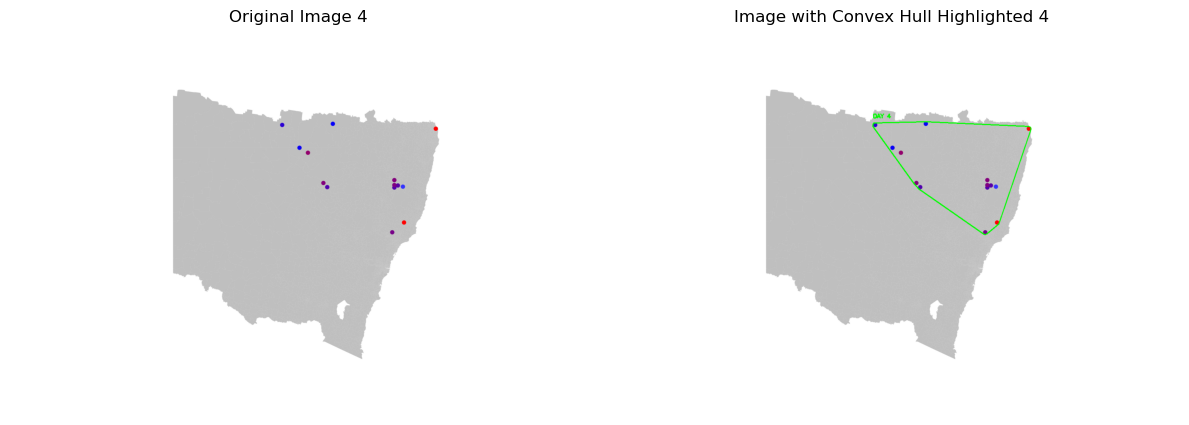

Processing image 5/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-15.png


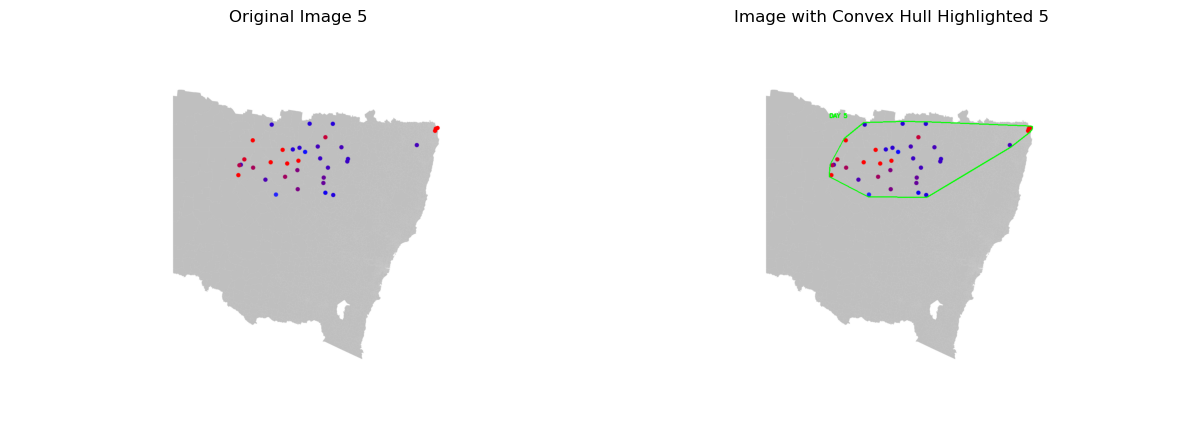

Processing image 6/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-16.png


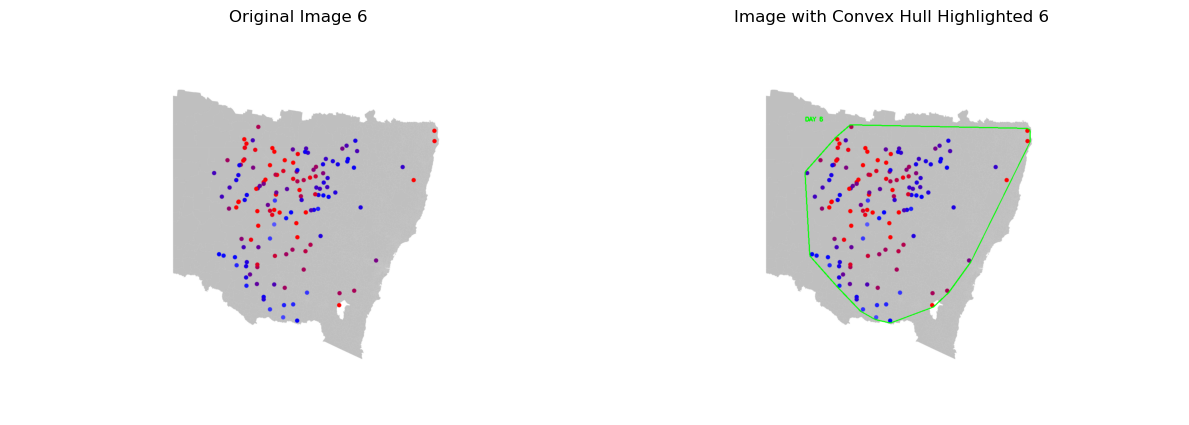

Processing image 7/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-17.png


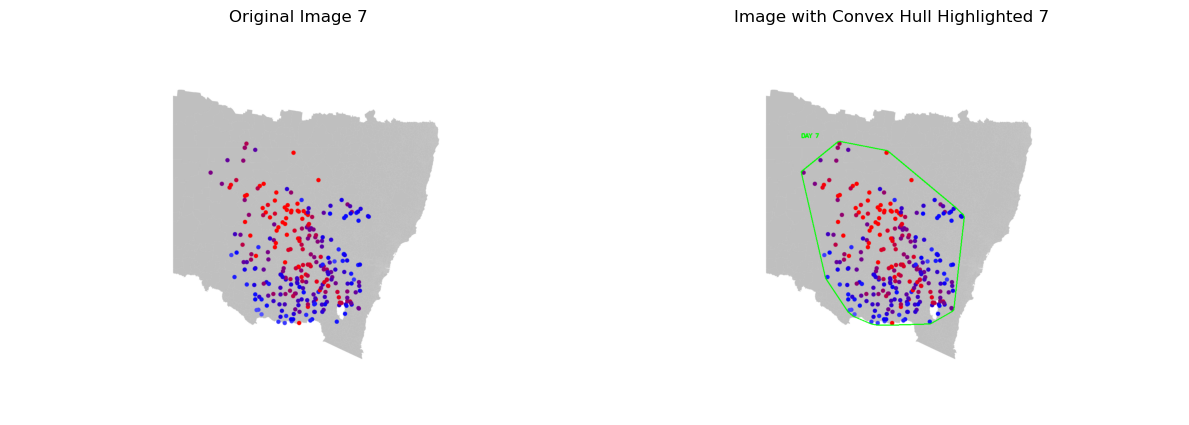

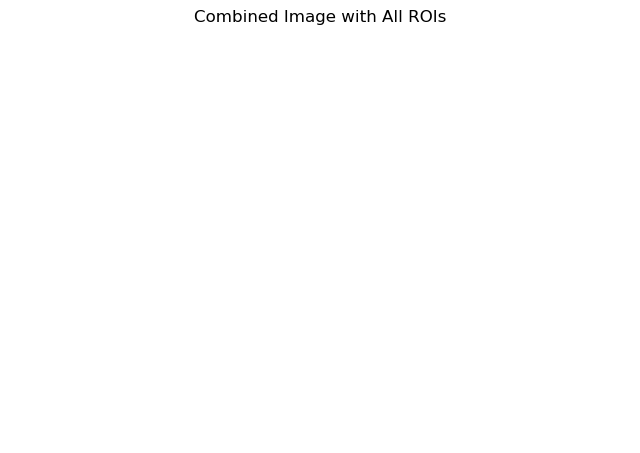

In [31]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
    return thresholded

def create_gif_from_images(save_path: str, image_path: str, ext: str, duration: int = 1500) -> None:
    ext = ext.replace('.', '')
    image_paths = sorted(glob.glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]
    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=duration, loop=0)

def draw_convex_hull(frame, contours, label):
    if contours:
        contours = np.vstack(contours)
        hull = cv2.convexHull(contours)
        cv2.drawContours(frame, [hull], -1, (0, 255, 0), 2)
        # Label the convex hull
        x, y, w, h = cv2.boundingRect(hull)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Path to save the output GIF
output_gif_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\output.gif'

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    combined_image = None

    # Iterate over all images and apply the thresholding
    for idx, image_path in enumerate(image_paths):
        print(f"Processing image {idx + 1}/{len(image_paths)}: {image_path}")

        # Load the image
        image = cv2.imread(image_path)

        if image is None:
            print(f"Unable to load image: {image_path}")
            continue
        
        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)
        
        # Find contours
        contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Filter contours based on area threshold (adjust as needed)
        min_contour_area = 50  # Example threshold for minimum contour area
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        # Draw convex hull on the original image
        image_with_hull = image.copy()
        draw_convex_hull(image_with_hull, contours, f"DAY {idx + 1}")

        # Display original and image with convex hull highlighted
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {idx + 1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_hull, cv2.COLOR_BGR2RGB))
        plt.title(f'Image with Convex Hull Highlighted {idx + 1}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Initialize combined_image if it's None
        if combined_image is None:
            combined_image = np.zeros_like(image_with_hull, dtype=np.uint8)

        # Combine current image's convex hull with the combined_image
        combined_image = cv2.addWeighted(combined_image, 1, image_with_hull, 1, 0)

    # Save the combined image with all convex hulls
    combined_image_path = os.path.join(directory_path, 'combined_image.png')
    cv2.imwrite(combined_image_path, combined_image)

    # Display combined image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.title('Combined Image with All ROIs')
    plt.axis('off')
    plt.show()

    # Create GIF from processed images
    create_gif_from_images(output_gif_path, directory_path, '.png')


Processing image 1/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-11.png


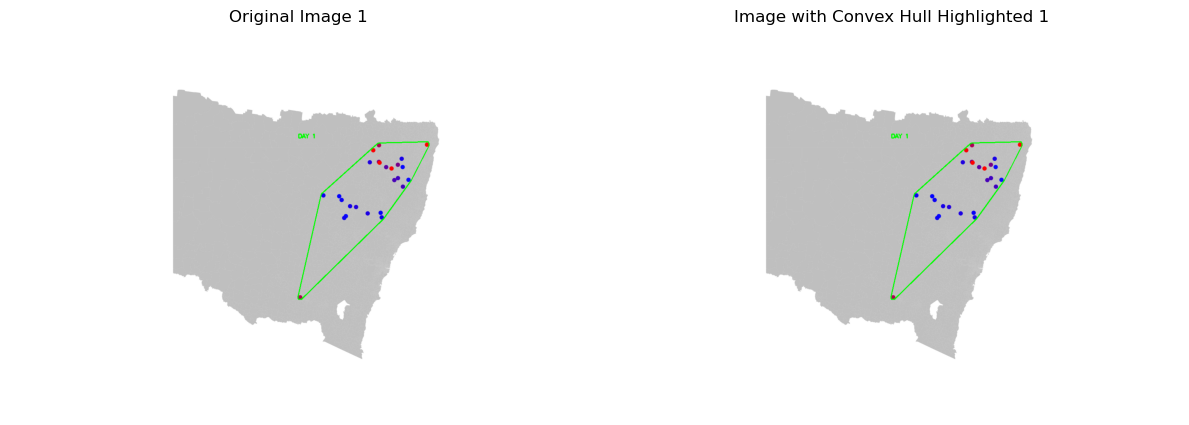

Processing image 2/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-12.png


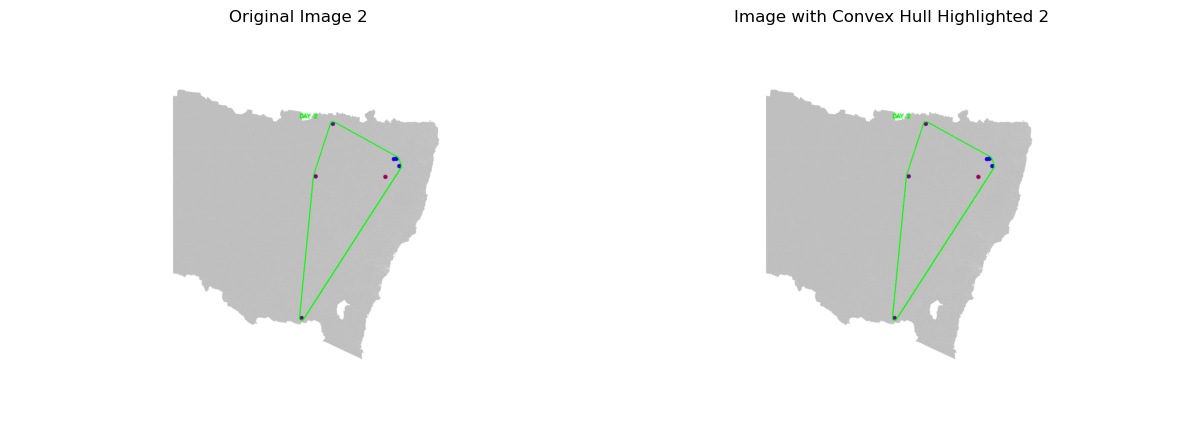

Processing image 3/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-13.png


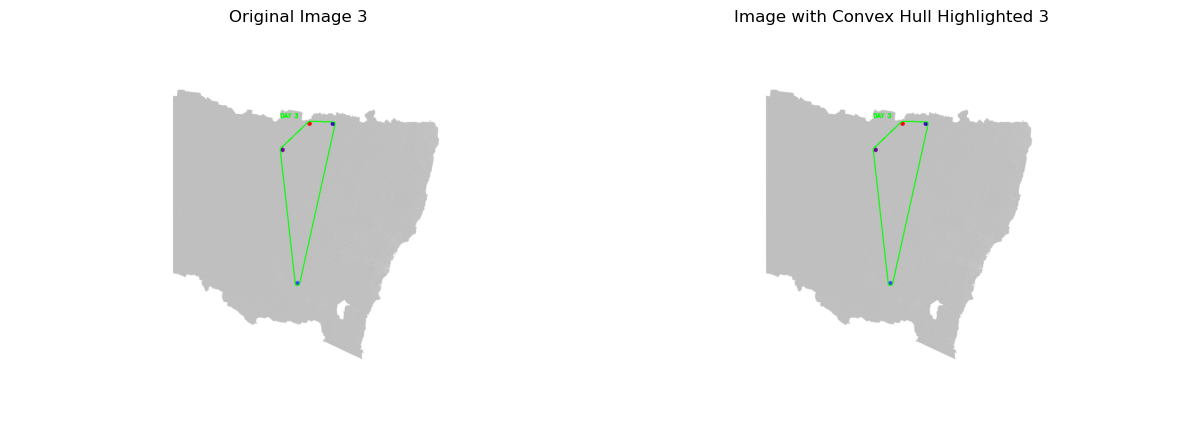

Processing image 4/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-14.png


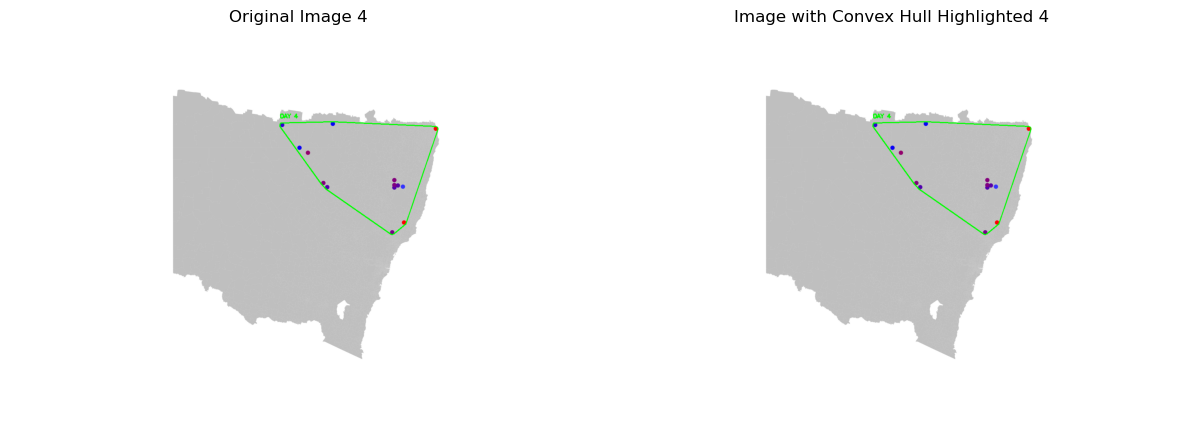

Processing image 5/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-15.png


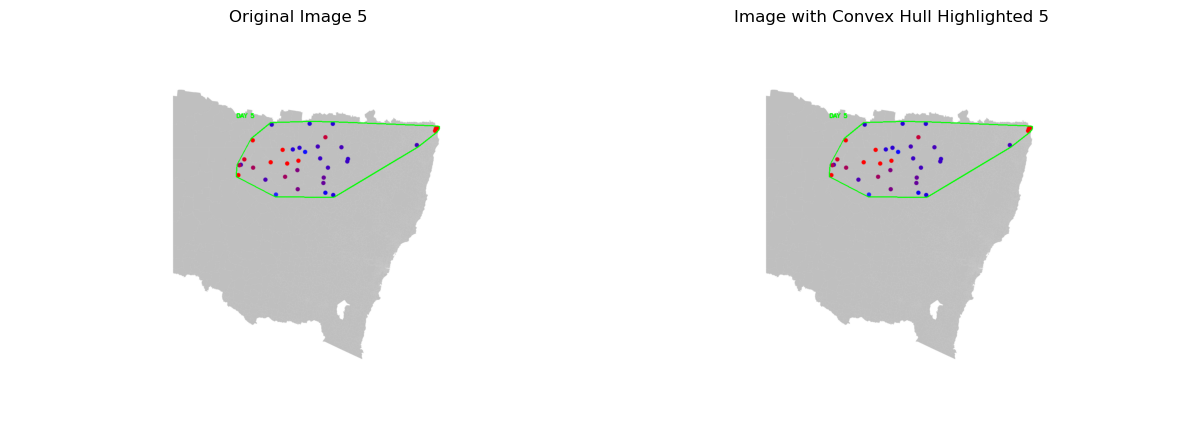

Processing image 6/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-16.png


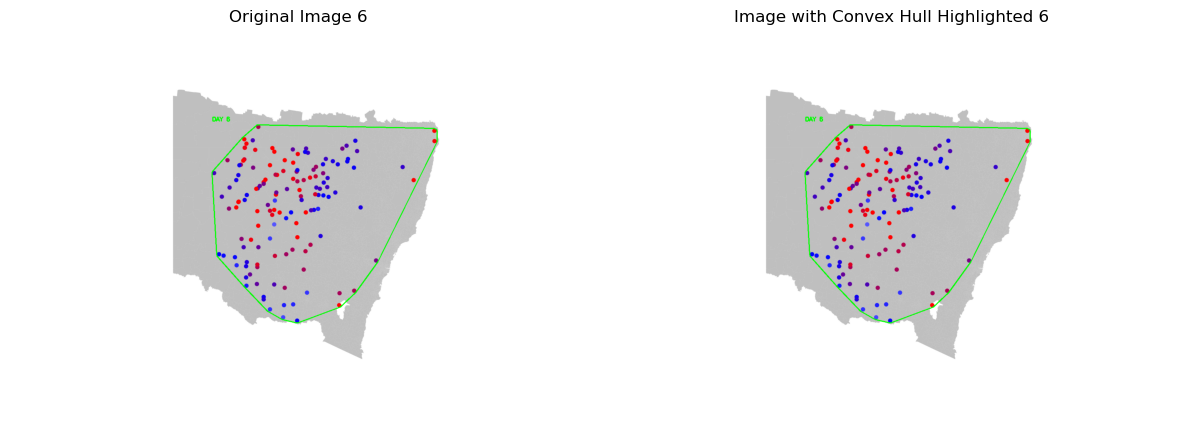

Processing image 7/7: C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17\Rainfall_Map_1891-01-17.png


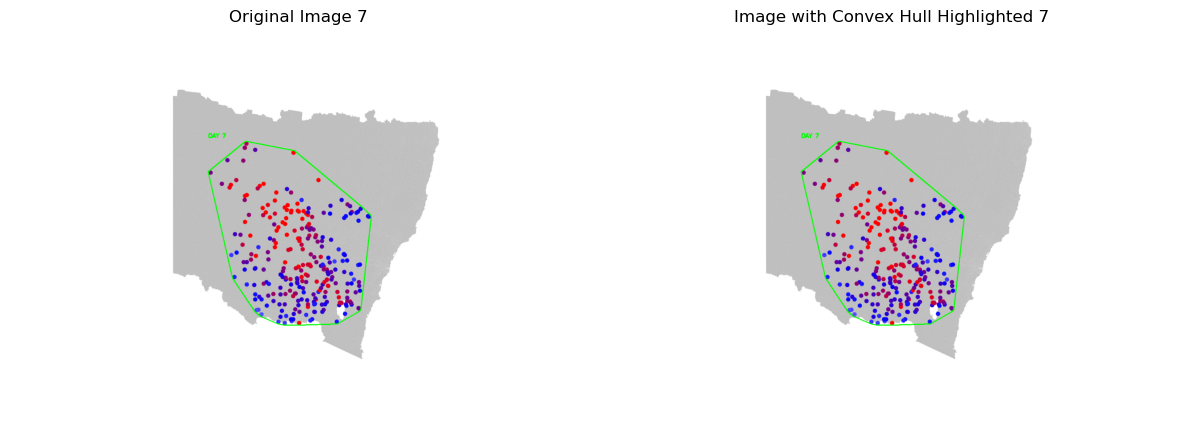

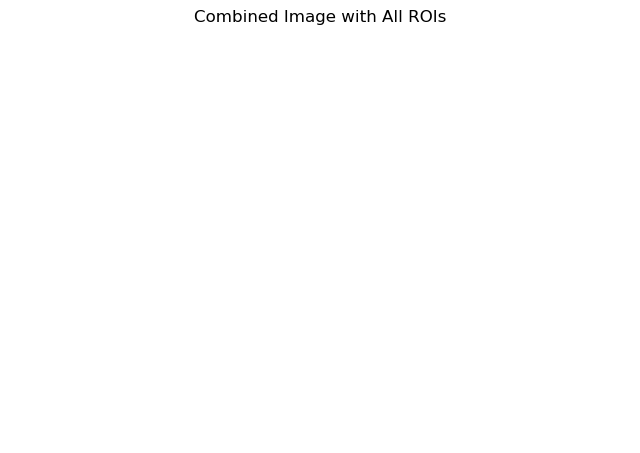

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

def find_max_intensity_roi(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to isolate areas of high intensity (red dots)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
    return thresholded

def create_gif_from_images(save_path: str, image_path: str, ext: str, duration: int = 1500) -> None:
    ext = ext.replace('.', '')
    image_paths = sorted(glob.glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]
    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=duration, loop=0)

def draw_convex_hull(frame, contours, label):
    if contours:
        contours = np.vstack(contours)
        hull = cv2.convexHull(contours)
        cv2.drawContours(frame, [hull], -1, (0, 255, 0), 2)
        # Label the convex hull
        x, y, w, h = cv2.boundingRect(hull)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))

# Path to save the output GIF
output_gif_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\output.gif'

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Initialize combined_image with the first image
    first_image = cv2.imread(image_paths[0])
    combined_image = np.zeros_like(first_image, dtype=np.uint8)

    # Iterate over all images and apply the thresholding
    for idx, image_path in enumerate(image_paths):
        print(f"Processing image {idx + 1}/{len(image_paths)}: {image_path}")

        # Load the image
        image = cv2.imread(image_path)

        if image is None:
            print(f"Unable to load image: {image_path}")
            continue
        
        # Apply find_max_intensity_roi function
        thresholded_image = find_max_intensity_roi(image)
        
        # Find contours
        contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Filter contours based on area threshold (adjust as needed)
        min_contour_area = 50  # Example threshold for minimum contour area
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        # Draw convex hull on the original image
        draw_convex_hull(image, contours, f"DAY {idx + 1}")

        # Display original and image with convex hull highlighted
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {idx + 1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Image with Convex Hull Highlighted {idx + 1}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Add the current image's convex hull to the combined_image
        combined_image = cv2.addWeighted(combined_image, 1, image, 0.5, 0)

    # Save the combined image with all convex hulls
    combined_image_path = os.path.join(directory_path, 'combined_image.png')
    cv2.imwrite(combined_image_path, combined_image)

    # Display combined image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.title('Combined Image with All ROIs')
    plt.axis('off')
    plt.show()

    # Create GIF from processed images
    create_gif_from_images(output_gif_path, directory_path, '.png')


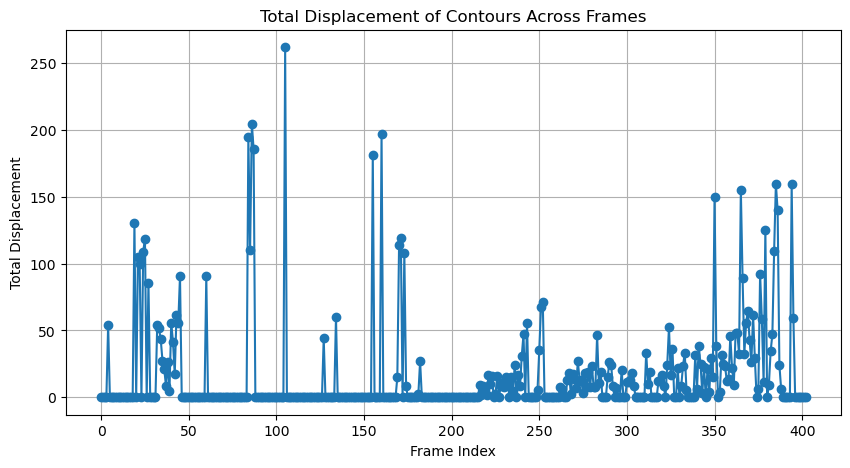

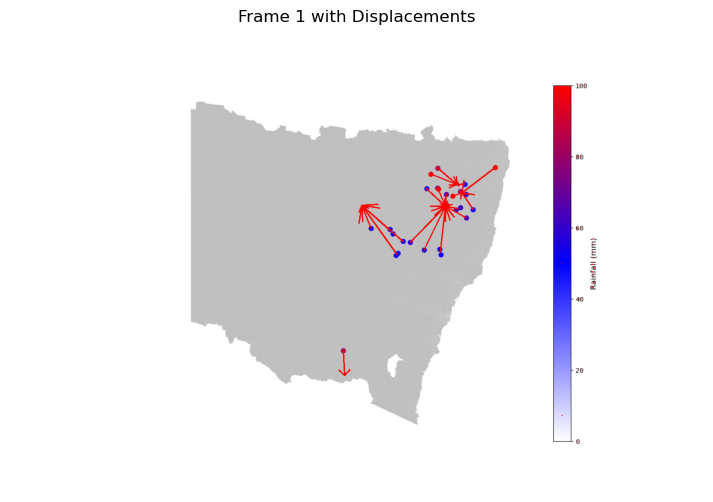

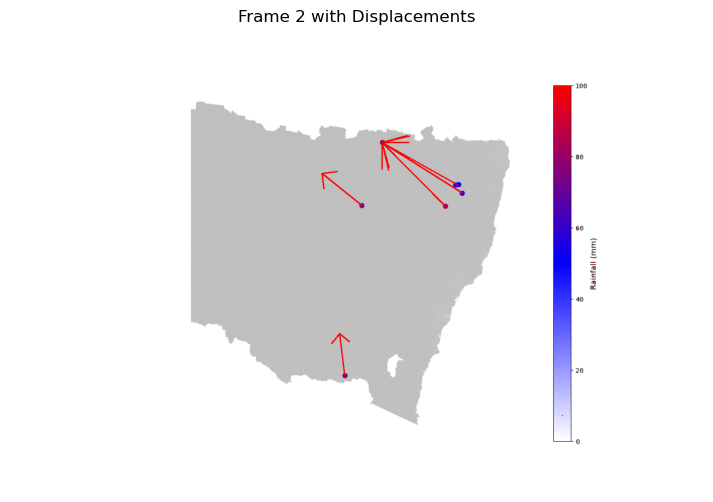

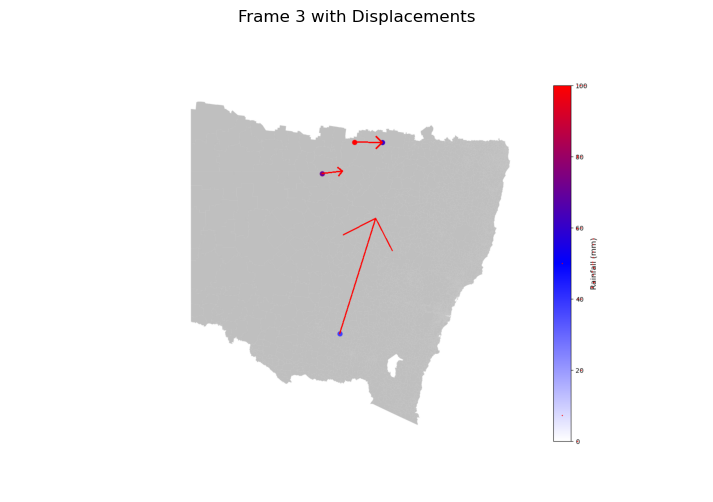

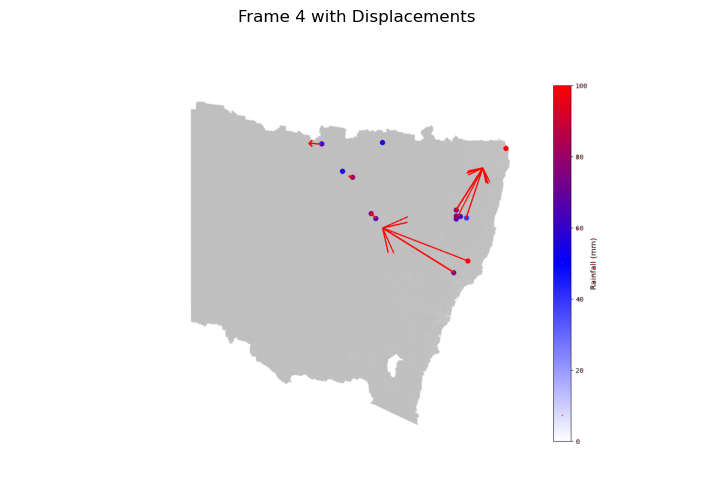

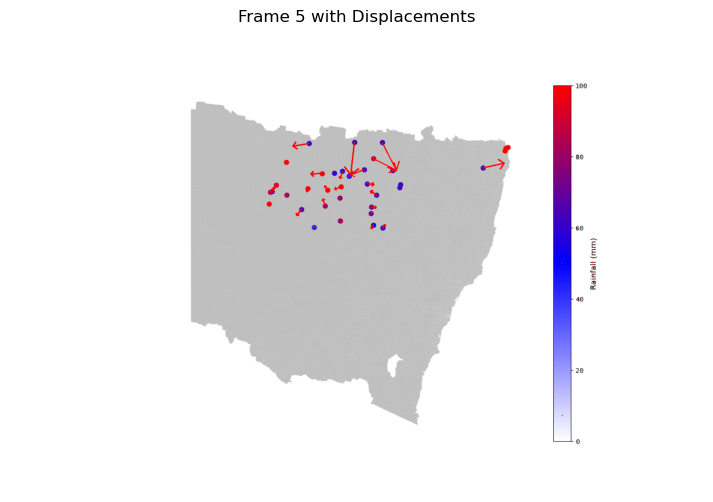

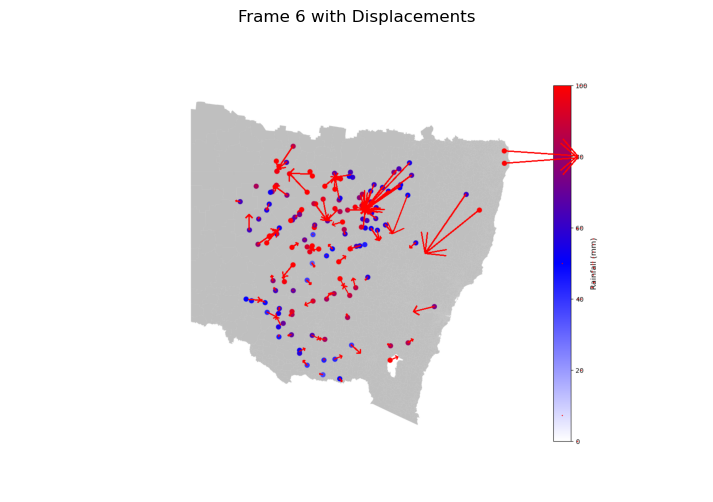

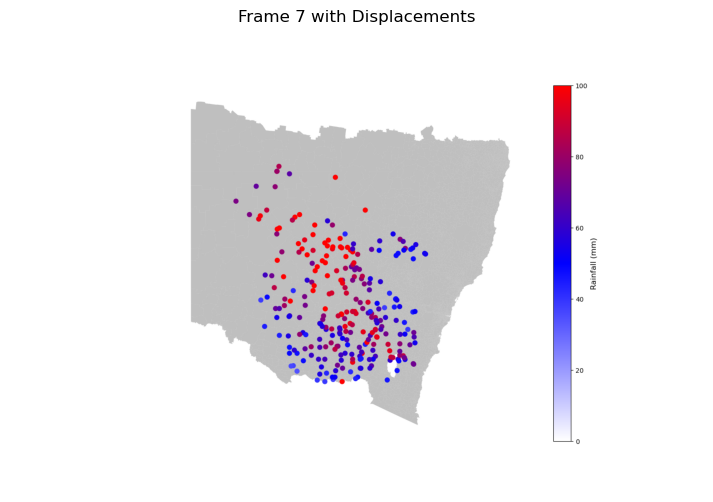

In [9]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

def find_max_intensity_roi(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
    return thresholded

def remove_contained_bboxes(boxes):
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(boxes)):
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

def non_max_suppression(boxes, scores, threshold=1e-1):
    boxes = boxes[np.argsort(scores)[::-1]]
    order = remove_contained_bboxes(boxes)
    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order[:]:
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

def draw_bboxes(frame, detections):
    for det in detections:
        x1, y1, x2, y2 = det
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

def create_gif_from_images(save_path: str, image_path: str, ext: str, duration: int = 1500) -> None:
    ext = ext.replace('.', '')
    image_paths = sorted(glob.glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]
    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=duration, loop=0)

def track_contours(image_paths):
    contours_per_frame = []

    for image_path in image_paths:
        image = cv2.imread(image_path)
        thresholded_image = find_max_intensity_roi(image)

        mask = np.zeros_like(thresholded_image)
        h, w = thresholded_image.shape
        cv2.rectangle(mask, (10, 10), (w-10, h-10), 255, -1)
        masked_thresholded_image = cv2.bitwise_and(thresholded_image, thresholded_image, mask=mask)

        contours, _ = cv2.findContours(masked_thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        min_contour_area = 10
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        centers = []
        for cnt in contours:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                centers.append((cX, cY))
        
        contours_per_frame.append(centers)

    return contours_per_frame

def calculate_displacement(contours_per_frame):
    displacements = []
    for i in range(len(contours_per_frame) - 1):
        frame_displacements = []
        for (cX1, cY1) in contours_per_frame[i]:
            closest_distance = float('inf')
            closest_center = None
            for (cX2, cY2) in contours_per_frame[i + 1]:
                distance = np.sqrt((cX2 - cX1) ** 2 + (cY2 - cY1) ** 2)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_center = (cX2, cY2)
            if closest_center:
                displacement = (closest_center[0] - cX1, closest_center[1] - cY1)
                frame_displacements.append(((cX1, cY1), displacement))
        displacements.append(frame_displacements)
    return displacements

def calculate_total_displacement(displacements_per_frame):
    total_displacements = []
    for frame_displacements in displacements_per_frame:
        for start, displacement in frame_displacements:
            total_displacement = np.sqrt(displacement[0]**2 + displacement[1]**2)
            total_displacements.append(total_displacement)
    return total_displacements

def draw_displacements(image, displacements):
    for (start, displacement) in displacements:
        end = (start[0] + displacement[0], start[1] + displacement[1])
        cv2.arrowedLine(image, start, end, (0, 0, 255), 2, tipLength=0.3)

# Directory containing images
directory_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 5 - 1891-01-11 to 1891-01-17'

# Get all PNG files in the directory
image_paths = glob.glob(os.path.join(directory_path, '*.png'))
image_paths.sort()

# Path to save the output GIF
output_gif_path = r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\output.gif'

# Check if there are any images in the directory
if len(image_paths) == 0:
    print("No images found in the directory.")
else:
    # Track contours across frames
    contours_per_frame = track_contours(image_paths)

    # Calculate displacements between consecutive frames
    displacements_per_frame = calculate_displacement(contours_per_frame)

    # Calculate total displacements
    total_displacements = calculate_total_displacement(displacements_per_frame)

    # Plot total displacements
    plt.figure(figsize=(10, 5))
    plt.plot(total_displacements, marker='o')
    plt.title('Total Displacement of Contours Across Frames')
    plt.xlabel('Frame Index')
    plt.ylabel('Total Displacement')
    plt.grid(True)
    plt.show()

    # Iterate over images and draw displacements
    for i in range(len(image_paths)):
        image = cv2.imread(image_paths[i])
        
        # Draw displacements if not the last frame
        if i < len(displacements_per_frame):
            draw_displacements(image, displacements_per_frame[i])

        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame {i+1} with Displacements')
        plt.axis('off')
        plt.show()

    # Create GIF from processed images
    create_gif_from_images(output_gif_path, directory_path, '.png')


In [3]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(r'C:\Users\RUCHITSANDIP\OneDrive - The University of Melbourne\Documents\Documents\Master thesis Data\BoM Station Dataset\Map_plots_specific_station\Event 1 - 1889-07-14 to 1889-07-20\Rainfall_Map_1889-07-16.png')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define color ranges and create masks
# White, blue, and red color ranges in HSV
color_ranges = {
    'white': ([0, 0, 200], [180, 55, 255]),
    'blue': ([100, 150, 0], [140, 255, 255]),
    'red1': ([0, 70, 50], [10, 255, 255]),
    'red2': ([170, 70, 50], [180, 255, 255])
}

# Create a blank mask to accumulate results
final_mask = np.zeros_like(hsv_image[:, :, 0])

# Iterate over color ranges to create masks and find contours
for color, (lower, upper) in color_ranges.items():
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    
    # Create a mask for the current color
    mask = cv2.inRange(hsv_image, lower, upper)
    final_mask = cv2.bitwise_or(final_mask, mask)

# Find contours on the accumulated mask
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding rectangles around each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Save or display the result
cv2.imshow('Result', image)
cv2.imwrite('result_with_rois.jpg', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Define directories and file paths
input_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events'
output_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_IDW_KDE_plots'
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
excel_file_path = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'  # Replace with the actual path to your Excel file

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))
zi = np.zeros(xi.shape)

# Read the Excel file and get the event names
excel_df = pd.read_excel(excel_file_path, sheet_name='Sheet6')
event_names = excel_df['Event'].dropna().unique()

# Function to perform Gaussian KDE
def perform_gaussian_kde(latitude, longitude, rainfall):
    try:
        xy = np.vstack([longitude, latitude])
        kde = gaussian_kde(xy, weights=rainfall, bw_method='scott')
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Function to perform IDW interpolation
def perform_idw(latitude, longitude, rainfall):
    try:
        for i in range(len(xi)):
            for j in range(len(yi)):
                distances = np.sqrt((longitude.values - xi[i, j])**2 + (latitude.values - yi[i, j])**2)
                weights = 1 / (distances + 1e-6)
                zi[i, j] = np.sum(weights * rainfall.values) / np.sum(weights)
        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Process each event
for event_name in event_names:
    try:
        # Construct the CSV file path
        csv_file_name = f'{event_name}.csv'
        csv_file_path = os.path.join(input_directory, csv_file_name)

        # Load the CSV file
        df = pd.read_csv(csv_file_path)

        # Extract necessary columns
        latitude = df['Latitude']
        longitude = df['Longitude']

        # Interpolate the rainfall data on the grid for each day
        rainfall_columns = [col for col in df.columns if 'Rainfall' in col]
        daily_means = []

        # Store peak points and colors
        peak_points = []
        peak_colors = []
        method_used = ""

        for col in rainfall_columns:
            method_used = ""  # Initialize method_used inside the loop
            x_cleaned = df[['Latitude', 'Longitude', col]].dropna()
            rainfall = x_cleaned[col]
            latitude = x_cleaned['Latitude']
            longitude = x_cleaned['Longitude']

            # First try Gaussian KDE method
            zi_smoothed, error = perform_gaussian_kde(latitude, longitude, rainfall)
            if error:
                print(f'Gaussian KDE failed for {event_name} on column {col}: {error}')
                # If KDE fails, try IDW method
                zi_smoothed, error = perform_idw(latitude, longitude, rainfall)
                if error:
                    print(f'IDW interpolation failed for {event_name} on column {col}: {error}')
                    continue
                else:
                    method_used = "IDW"
            else:
                method_used = "Gaussian KDE"

            # Detect the highest peak (center of the contour)
            peak_index = np.unravel_index(np.nanargmax(zi_smoothed), zi_smoothed.shape)
            peak_y, peak_x = peak_index

            # Mask the grid to include only points inside the shapefile geometry
            points = np.vstack((xi.flatten(), yi.flatten())).T
            mask = np.array([gdf.contains(Point(point)).any() for point in points])
            mask = mask.reshape(xi.shape)
            zi_smoothed = np.where(mask, zi_smoothed, np.nan)

            # Extract stations within the 90th percentile of the highest shaded contour
            contour_level = np.percentile(zi_smoothed[~np.isnan(zi_smoothed)], 90)
            contour_stations = x_cleaned[(zi_smoothed[(np.digitize(latitude, yi[:, 0]), np.digitize(longitude, xi[0]))] >= contour_level)]

            # Extract top 5 stations with highest rainfall
            top_stations = contour_stations.nlargest(5, col)

            # Apply .describe() to these stations
            top_stations_description = top_stations.describe()

            # Calculate daily mean rainfall
            daily_mean = top_stations[col].mean()
            daily_means.append(daily_mean)

            # Store peak points
            peak_points.append((xi[peak_y, peak_x], yi[peak_y, peak_x]))

        # Calculate total mean of all daily means and 25th percentile
        total_mean = np.mean(daily_means)
        percentile_25th = np.percentile(daily_means, 25)

        # Determine peak colors based on the 25th percentile
        peak_colors = ['red' if mean > percentile_25th else 'green' for mean in daily_means]

        # Plotting the map with peaks connected by lines and annotated
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, color='gray', edgecolor='none')

        # Plot contours
        for col in rainfall_columns:
            x_cleaned = df[['Latitude', 'Longitude', col]].dropna()
            rainfall = x_cleaned[col]
            latitude = x_cleaned['Latitude']
            longitude = x_cleaned['Longitude']

            # First try Gaussian KDE method
            zi_smoothed, error = perform_gaussian_kde(latitude, longitude, rainfall)
            if error:
                # If KDE fails, try IDW method
                zi_smoothed, error = perform_idw(latitude, longitude, rainfall)

            if zi_smoothed is not None:
                points = np.vstack((xi.flatten(), yi.flatten())).T
                mask = np.array([gdf.contains(Point(point)).any() for point in points])
                mask = mask.reshape(xi.shape)
                zi_smoothed = np.where(mask, zi_smoothed, np.nan)

        

        # Connect peaks with lines and annotate
        for i, (point, color) in enumerate(zip(peak_points, peak_colors)):
            ax.plot(point[0], point[1], 'o', color=color)
            if i > 0 and color == 'red' and peak_colors[i - 1] == 'red':
                prev_point = peak_points[i - 1]
                ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='red')
            ax.annotate(f'{i+1}', xy=point, xytext=(5, -5), textcoords='offset points')

        # Set the title to the event name
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'({event_name})')

        # Save the plot
        output_file_path = os.path.join(output_directory, f'{event_name}.png')
        plt.savefig(output_file_path)
        plt.close()

        print(f'Successfully processed: {event_name} using {method_used} method')

    except Exception as e:
        print(f'Error processing {event_name}: {e}')


Successfully processed: Event 733 - 1895-11-15 to 1895-11-21 using Gaussian KDE method
Successfully processed: Event 734 - 1874-01-11 to 1874-01-17 using Gaussian KDE method
Successfully processed: Event 735 - 1892-12-13 to 1892-12-19 using Gaussian KDE method
Successfully processed: Event 736 - 1900-01-17 to 1900-01-23 using Gaussian KDE method
Successfully processed: Event 737 - 1887-12-14 to 1887-12-20 using Gaussian KDE method
Successfully processed: Event 738 - 1892-06-19 to 1892-06-25 using Gaussian KDE method
Successfully processed: Event 739 - 1889-02-19 to 1889-02-25 using Gaussian KDE method
Successfully processed: Event 740 - 1891-12-10 to 1891-12-16 using Gaussian KDE method
Successfully processed: Event 741 - 1894-04-26 to 1894-05-02 using Gaussian KDE method
Successfully processed: Event 742 - 1896-01-13 to 1896-01-19 using Gaussian KDE method
Gaussian KDE failed for Event 743 - 1878-04-25 to 1878-05-01 on column Rainfall 1878-05-01: The data appears to lie in a lower-dim

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 790 - 1870-12-28 to 1871-01-03 on column Rainfall 1871-01-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 790 - 1870-12-28 to 1871-01-03 using IDW method
Successfully processed: Event 791 - 1871-10-24 to 1871-10-30 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 792 - 1871-11-02 to 1871-11-08 on column Rainfall 1871-11-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 792 - 1871-11-02 to 1871-11-08 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 793 - 1872-11-10 to 1872-11-16 on column Rainfall 1872-11-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 793 - 1872-11-10 to 1872-11-16 on column Rainfall 1872-11-16: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 793 - 1872-11-10 to 1872-11-16 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 794 - 1876-01-02 to 1876-01-08 on column Rainfall 1876-01-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 794 - 1876-01-02 to 1876-01-08 on column Rainfall 1876-01-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 794 - 1876-01-02 to 1876-01-08 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 795 - 1876-12-23 to 1876-12-29 on column Rainfall 1876-12-29: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 795 - 1876-12-23 to 1876-12-29 using IDW method
Successfully processed: Event 796 - 1878-08-30 to 1878-09-05 using Gaussian KDE method
Successfully processed: Event 797 - 1880-11-27 to 1880-12-03 using Gaussian KDE method
Gaussian KDE failed for Event 798 - 1883-02-18 to 1883-02-24 on column Rainfall 1883-02-21: aweights cannot be negative
Successfully processed: Event 798 - 1883-02-18 to 1883-02-24 using Gaussian KDE method
Successfully processed: Event 799 - 1894-03-30 to 1894-04-05 using Gaussian KDE method
Successfully processed: Event 800 - 1886-02-22 to 1886-02-28 using Gaussian KDE method
Successfully processed: Event 801 - 1885-12-05 to 1885-12-11 using Gaussian KDE method
Successfully processed: Event 802 - 1886-11-18 to 1886-11-24 using Gaussian KDE method
Successfully processed: Event 803 - 1886-04-18 to 1886-04-24 using Gaussian KDE method
Successfully processed: Event 804 - 1893-05-11 to 1893-05-17 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 805 - 1878-11-28 to 1878-12-04 on column Rainfall 1878-12-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 805 - 1878-11-28 to 1878-12-04 on column Rainfall 1878-12-04: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 805 - 1878-11-28 to 1878-12-04 using IDW method
Gaussian KDE failed for Event 806 - 1898-02-04 to 1898-02-10 on column Rainfall 1898-02-08: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 806 - 1898-02-04 to 1898-02-10 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 807 - 1872-05-31 to 1872-06-06 on column Rainfall 1872-06-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 807 - 1872-05-31 to 1872-06-06 using IDW method
Successfully processed: Event 808 - 1873-05-28 to 1873-06-03 using Gaussian KDE method
Gaussian KDE failed for Event 809 - 1873-09-02 to 1873-09-08 on column Rainfall 1873-09-07: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 809 - 1873-09-02 to 1873-09-08 on column Rainfall 1873-09-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 809 - 1873-09-02 to 1873-09-08 using IDW method
Successfully processed: Event 810 - 1874-02-07 to 1874-02-13 using Gaussian KDE method
Successfully processed: Event 811 - 1874-03-01 to 1874-03-07 using Gaussian KDE method
Successfully processed: Event 812 - 1874-03-27 to 1874-04-02 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 813 - 1876-03-23 to 1876-03-29 on column Rainfall 1876-03-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 813 - 1876-03-23 to 1876-03-29 using Gaussian KDE method
Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-04: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 814 - 1876-11-01 to 1876-11-07 on column Rainfall 1876-11-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divid

Successfully processed: Event 814 - 1876-11-01 to 1876-11-07 using IDW method
Gaussian KDE failed for Event 815 - 1877-06-07 to 1877-06-13 on column Rainfall 1877-06-12: aweights cannot be negative
Successfully processed: Event 815 - 1877-06-07 to 1877-06-13 using Gaussian KDE method
Gaussian KDE failed for Event 816 - 1877-09-07 to 1877-09-13 on column Rainfall 1877-09-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 816 - 1877-09-07 to 1877-09-13 on column Rainfall 1877-09-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 816 - 1877-09-07 to 1877-09-13 using Gaussian KDE method
Gaussian KDE failed for Event 817 - 1877-09-15 to 1877-09-21 on column Rainfall 1877-09-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 817 - 1877-09-15 to 1877-09-21 on column Rainfall 1877-09-16: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 817 - 1877-09-15 to 1877-09-21 using Gaussian KDE method
Successfully processed: Event 818 - 1878-06-20 to 1878-06-26 using Gaussian KDE method
Gaussian KDE failed for Event 819 - 1885-12-17 to 1885-12-23 on column Rainfall 1885-12-23: aweights cannot be negative
Successfully processed: Event 819 - 1885-12-17 to 1885-12-23 using IDW method
Successfully processed: Event 820 - 1885-07-12 to 1885-07-18 using Gaussian KDE method
Successfully processed: Event 821 - 1886-01-04 to 1886-01-10 using Gaussian KDE method
Successfully processed: Event 822 - 1881-11-18 to 1881-11-24 using Gaussian KDE method
Successfully processed: Event 823 - 1888-08-03 to 1888-08-09 using Gaussian KDE method
Successfully processed: Event 824 - 1895-03-13 to 1895-03-19 using Gaussian KDE method
Successfully processed: Event 825 - 1899-03-03 to 1899-03-09 using Gaussian KDE method
Successfully processed: Event 826 - 1900-09-18 to 1900-09-24 using Gaussian KDE method
Successfully proces

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 828 - 1872-12-27 to 1873-01-02 on column Rainfall 1872-12-28: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 828 - 1872-12-27 to 1873-01-02 on column Rainfall 1873-01-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 828 - 1872-12-27 to 1873-01-02 using Gaussian KDE method
Successfully processed: Event 829 - 1880-05-23 to 1880-05-29 using Gaussian KDE method
Successfully processed: Event 830 - 1885-03-27 to 1885-04-02 using Gaussian KDE method
Successfully processed: Event 831 - 1885-03-01 to 1885-03-07 using Gaussian KDE method
Gaussian KDE failed for Event 832 - 1885-04-11 to 1885-04-17 on column Rainfall 1885-04-15: aweights cannot be negative
Gaussian KDE failed for Event 832 - 1885-04-11 to 1885-04-17 on column Rainfall 1885-04-17: aweights cannot be negative
Successfully processed: Event 832 - 1885-04-11 to 1885-04-17 using IDW method
Successfully processed: Event 833 - 1895-03-05 to 1895-03-11 using Gaussian KDE method
Successfully processed: Event 834 - 1892-02-04 to 1892-02-10 using Gaussian KDE method
Successfully processed: Event 835 - 1886-01-12 to 1886-01-18 using Gaussian KDE method
Successfully processed: Event 836 - 1894-04-07 to 1894-04-13 using Gaussi

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 837 - 1883-11-17 to 1883-11-23 on column Rainfall 1883-11-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 837 - 1883-11-17 to 1883-11-23 using IDW method
Successfully processed: Event 838 - 1886-11-26 to 1886-12-02 using Gaussian KDE method
Successfully processed: Event 839 - 1889-02-02 to 1889-02-08 using Gaussian KDE method
Successfully processed: Event 840 - 1889-04-11 to 1889-04-17 using Gaussian KDE method
Successfully processed: Event 841 - 1900-12-17 to 1900-12-23 using Gaussian KDE method
Successfully processed: Event 842 - 1896-12-11 to 1896-12-17 using Gaussian KDE method
Successfully processed: Event 843 - 1898-10-13 to 1898-10-19 using Gaussian KDE method
Successfully processed: Event 844 - 1900-04-01 to 1900-04-07 using Gaussian KDE method
Successfully processed: Event 845 - 1897-10-04 to 1897-10-10 using Gaussian KDE method
Successfully processed: Event 846 - 1891-12-06 to 1891-12-12 using Gaussian KDE method
Successfully processed: Event 847 - 1893-03-29 to 1893-04-04 using Gaussian KDE method
Successfully processed: Event 848 - 1900-08-28 to 19

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 849 - 1882-11-24 to 1882-11-30 using Gaussian KDE method
Gaussian KDE failed for Event 850 - 1879-07-06 to 1879-07-12 on column Rainfall 1879-07-12: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 850 - 1879-07-06 to 1879-07-12 using IDW method
Gaussian KDE failed for Event 851 - 1881-10-12 to 1881-10-18 on column Rainfall 1881-10-18: aweights cannot be negative
Successfully processed: Event 851 - 1881-10-12 to 1881-10-18 using IDW method
Successfully processed: Event 852 - 1886-12-06 to 1886-12-12 using Gaussian KDE method
Successfully processed: Event 853 - 1877-02-25 to 1877-03-03 using Gaussian KDE method
Successfully pro

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 860 - 1880-04-07 to 1880-04-13 on column Rainfall 1880-04-09: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 860 - 1880-04-07 to 1880-04-13 using Gaussian KDE method
Successfully processed: Event 861 - 1900-06-19 to 1900-06-25 using Gaussian KDE method
Successfully processed: Event 862 - 1875-01-28 to 1875-02-03 using Gaussian KDE method
Successfully processed: Event 863 - 1880-02-29 to 1880-03-06 using Gaussian KDE method
Successfully processed: Event 864 - 1898-09-09 to 1898-09-15 using Gaussian KDE method
Gaussian KDE failed for Event 865 - 1895-01-10 to 1895-01-16 on column Rainfall 1895-01-16: aweights cannot be negative
Successfully processed: Event 865 - 1895-01-10 to 1895-01-16 using IDW method
Successfully processed: Event 866 - 1895-02-10 to 1895-02-16 using Gaussian KDE method
Successfully processed: Event 867 - 1894-02-20 to 1894-02-26 using Gaussian KDE method
Successfully processed: Event 868 - 1884-02-04 to 1884-02-10 using Gaussian KDE method
Successfully processed: Event 869 - 1890-03-27 to 1890-04-02 using Gaussian KDE method
Gaussian KDE failed

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 872 - 1873-10-29 to 1873-11-04 on column Rainfall 1873-11-02: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 872 - 1873-10-29 to 1873-11-04 using Gaussian KDE method
Successfully processed: Event 873 - 1884-02-17 to 1884-02-23 using Gaussian KDE method
Successfully processed: Event 874 - 1887-06-08 to 1887-06-14 using Gaussian KDE method
Successfully processed: Event 875 - 1892-01-05 to 1892-01-11 using Gaussian KDE method
Successfully processed: Event 876 - 1882-08-25 to 1882-08-31 using Gaussian KDE method
Successfully processed: Event 877 - 1895-10-04 to 1895-10-10 using Gaussian KDE method
Successfully processed: Event 878 - 1895-12-23 to 1895-12-29 using Gaussian KDE method
Gaussian KDE failed for Event 879 - 1894-08-18 to 1894-08-24 on column Rainfall 1894-08-21: aweights cannot be negative
Successfully processed: Event 879 - 1894-08-18 to 1894-08-24 using Gaussian KDE method
Successfully processed: Event 880 - 1889-10-14 to 1889-10-20 using Gaussian KDE method
Gaussian KDE failed for Event 881 - 1858-02-01 to 1858-02-07 on column Rainfall 1858-02-01: array

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 881 - 1858-02-01 to 1858-02-07 on column Rainfall 1858-02-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 881 - 1858-02-01 to 1858-02-07 on column Rainfall 1858-02-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 881 - 1858-02-01 to 1858-02-07 on column Rainfall 1858-02-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 881 - 1858-02-01 to 1858-02-07 using IDW method
Gaussian KDE failed for Event 882 - 1860-03-24 to 1860-03-30 on column Rainfall 1860-03-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 882 - 1860-03-24 to 1860-03-30 on column Rainfall 1860-03-25: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 882 - 1860-03-24 to 1860-03-30 on column Rainfall 1860-03-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 882 - 1860-03-24 to 1860-03-30 on column Rainfall 1860-03-30: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 882 - 1860-03-24 to 1860-03-30 using IDW method
Gaussian KDE failed for Event 883 - 1861-02-06 to 1861-02-12 on column Rainfall 1861-02-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 883 - 1861-02-06 to 1861-02-12 on column Rainfall 1861-02-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 883 - 1861-02-06 to 1861-02-12 using Gaussian KDE method
Gaussian KDE failed for Event 884 - 1862-04-03 to 1862-04-09 on column Rainfall 1862-04-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 884 - 1862-04-03 to 1862-04-09 on column Rainfall 1862-04-04: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Gaussian KDE failed for Event 884 - 1862-04-03 to 1862-04-09 on column Rainfall 1862-04-08: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 884 - 1862-04-03 to 1862-04-09 using Gaussian KDE method
Gaussian KDE failed for Event 885 - 1871-06-16 to 1871-06-22 on column Rainfall 1871-06-16: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 885 - 1871-06-16 to 1871-06-22 using Gaussian KDE method
Successfully processed: Event 886 - 1876-10-10 to 1876-10-16 using Gaussian KDE method
Successfully processed: Event 887 - 1897-02-12 to 1897-02-18 using Gaussian KDE method
Successfully processed: Event 888 - 1888-03-18 to 1888-03-24 using Gaussian KDE method
Successfully processed: Event 889 - 1888-05-27 to 1888-06-02 using Gaussian KDE method
Successfully processed: Event 890 - 1894-10-04 to 1894-10-10 using Gaussian KDE method
Successfully processed: Event 891 - 1880-04-12 to 1880-04-18 using Gaussian KDE method
Successfully processed: Event 892 - 1891-10-19 to 1891-10-25 using Gaussian KDE method
Successfully processed: Event 893 - 1886-03-22 to 1886-03-28 using Gaussian KDE method
Successfully processed: Event 894 - 1881-02-27 to 1881-03-05 using Gaussian KDE method
Successfully processed: Event 895 - 1892-10-10 to 1892-10-16 using Gaussian KDE method
Successfully processed: Event 896 - 1890-10

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 909 - 1873-09-30 to 1873-10-06 on column Rainfall 1873-10-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 909 - 1873-09-30 to 1873-10-06 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 910 - 1875-01-02 to 1875-01-08 on column Rainfall 1875-01-03: array must not contain infs or NaNs
Gaussian KDE failed for Event 910 - 1875-01-02 to 1875-01-08 on column Rainfall 1875-01-04: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 910 - 1875-01-02 to 1875-01-08 using Gaussian KDE method
Successfully processed: Event 911 - 1876-07-15 to 1876-07-21 using Gaussian KDE method
Successfully processed: Event 912 - 1878-02-20 to 1878-02-26 using Gaussian KDE method
Gaussian KDE failed for Event 913 - 1879-11-02 to 1879-11-08 on column Rainfall 1879-11-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 913 - 1879-11-02 to 1879-11-08 using Gaussian KDE method
Gaussian KDE failed for Event 914 - 1887-06-18 to 1887-06-24 on column Rainfall 1887-06-22: aweights cannot be negative
Successfully processed: Event 914 - 1887-06-18 to 1887-06-24 using Gaussian KDE method
Successfully processed: Event 915 - 1887-06-27 to 1887-07-03 using Gaussian KDE method
